# Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 1. Data Loading

### 1.1 Dataset Scale

In [2]:
filepath = '/Users/wanghelin/Documents/course/CS5344/project/dataset/loans_train.csv'
df = pd.read_csv(filepath)
print(f"Train dataset scale: {df.shape}")
print(df['target'].value_counts())

Train dataset scale: (30504, 145)
target
0    30504
Name: count, dtype: int64


In [3]:
filepath = '/Users/wanghelin/Documents/course/CS5344/project/dataset/loans_valid.csv'
df_val = pd.read_csv(filepath)
print(f"Validation dataset scale: {df_val.shape}")
print(df_val['target'].value_counts())
print(f"There are {df_val['target'].value_counts()[1]/len(df_val)*100:.2f}% of abnormal loans in validation dataset")

Validation dataset scale: (5370, 145)
target
0    4693
1     677
Name: count, dtype: int64
There are 12.61% of abnormal loans in validation dataset


### 1.2 Features

In [4]:
target_col = 'target'
features = [col for col in df.columns if col != target_col]
print(f"The target column is {target_col}")
print(f"There are {len(features)} features in total")

The target column is target
There are 144 features in total


In [5]:
index = "index"
static_features = ['CreditScore', 'FirstPaymentDate', 'FirstTimeHomebuyerFlag', 'MaturityDate', 'MSA', 'MI_Pct', 'NumberOfUnits', 'OccupancyStatus',
                   'OriginalCLTV', 'OriginalDTI', 'OriginalUPB', 'OriginalLTV', 'OriginalInterestRate', 'Channel', 'PPM_Flag', 'ProductType', 
                   'PropertyState', 'PropertyType', 'PostalCode', 'LoanPurpose', 'OriginalLoanTerm', 'NumberOfBorrowers', 'SellerName', 'ServicerName', 
                   'SuperConformingFlag', 'PreHARP_Flag', 'ProgramIndicator', 'ReliefRefinanceIndicator', 'PropertyValMethod', 'InterestOnlyFlag', 'BalloonIndicator']
base_dynamic_features = ['CurrentActualUPB', 'CurrentInterestRate', 'CurrentNonInterestBearingUPB', 'EstimatedLTV', 'InterestBearingUPB', 'LoanAge', 'MonthlyReportingPeriod', 'RemainingMonthsToLegalMaturity']
dynamic_features = [f"{i}_{feat}" for feat in base_dynamic_features for i in range(0, 14)]
print(f"There are {len(static_features)} static features in total(index is not included)")
print(f"There are {len(base_dynamic_features)} dynamic features in total. Each loan has 14 monthly reports, so there are {len(dynamic_features)} dynamic features in total")

There are 31 static features in total(index is not included)
There are 8 dynamic features in total. Each loan has 14 monthly reports, so there are 112 dynamic features in total


## 2. Static Data Analysis

### 2.1 DateTime Features

- **FirstPaymentDate**: First repayment date
- **MaturityDate**: Loan maturity date

These are not useful predictors of the target. The loan duration is already captured by *OriginalLoanTerm*, so both features can be dropped.

### 2.2 Binary Features

#### 2.2.1 Distribution in training set

In [23]:
binary_features = [
    'FirstTimeHomebuyerFlag',   # Y/N/9
    'PPM_Flag',                 # Y/N
    'SuperConformingFlag',      # Y/N
    'InterestOnlyFlag',         # Y/N
    'BalloonIndicator'          # Y/N/7
]

In [24]:
# 1. BASIC STATISTICS
summary_data = []

for feature in binary_features:
    null_count = df[feature].isnull().sum()
    null_pct = (null_count / len(df)) * 100
    
    # Get non-null value counts
    non_null_counts = df[feature].value_counts(dropna=False)
    total_non_null = len(df) - null_count
    
    # Determine if it's truly binary or has unknown codes
    unique_vals = [str(x) for x in df[feature].unique() if pd.notna(x)]
    
    true_counts = non_null_counts.get('Y', 0)
    true_pct = (true_counts / total_non_null) * 100
    false_counts = non_null_counts.get('N', 0)
    false_pct = (false_counts / total_non_null) * 100
    unknown_counts = non_null_counts.get('7', 0)
    unknown_pct = (unknown_counts / total_non_null) * 100
    
    summary_data.append({
        'Feature': feature,
        'Null_Pct': f"{null_pct:.2f}%",
        'Unique_Values': ', '.join(unique_vals),
        'True_Pct': f"{true_pct:.2f}%",
        'False_Pct': f"{false_pct:.2f}%",
        'Unknown_Pct': f"{unknown_pct:.2f}%",
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


               Feature Null_Pct Unique_Values True_Pct False_Pct Unknown_Pct
FirstTimeHomebuyerFlag    0.00%          N, Y   40.43%    59.57%       0.00%
              PPM_Flag    0.00%             N    0.00%   100.00%       0.00%
   SuperConformingFlag   98.92%             Y  100.00%     0.00%       0.00%
      InterestOnlyFlag    0.00%             N    0.00%   100.00%       0.00%
      BalloonIndicator    0.00%       7, N, Y    0.80%    36.21%      62.99%


In [25]:
binary_mapping = {
    'Y': 1,
    'N': 0
}
df[binary_features] = df[binary_features].replace(binary_mapping).astype('float')
df[binary_features] = df[binary_features].mask(~df[binary_features].isin([0, 1]), -1)
df_val[binary_features] = df_val[binary_features].replace(binary_mapping).astype('float')
df_val[binary_features] = df_val[binary_features].mask(~df_val[binary_features].isin([0, 1]), -1)

/var/folders/sm/spjvjp6d3y11l0_p48nnv5gh0000gn/T/ipykernel_63266/3991277519.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_features] = df[binary_features].replace(binary_mapping).astype('float')
/var/folders/sm/spjvjp6d3y11l0_p48nnv5gh0000gn/T/ipykernel_63266/3991277519.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_val[binary_features] = df_val[binary_features].replace(binary_mapping).astype('float')


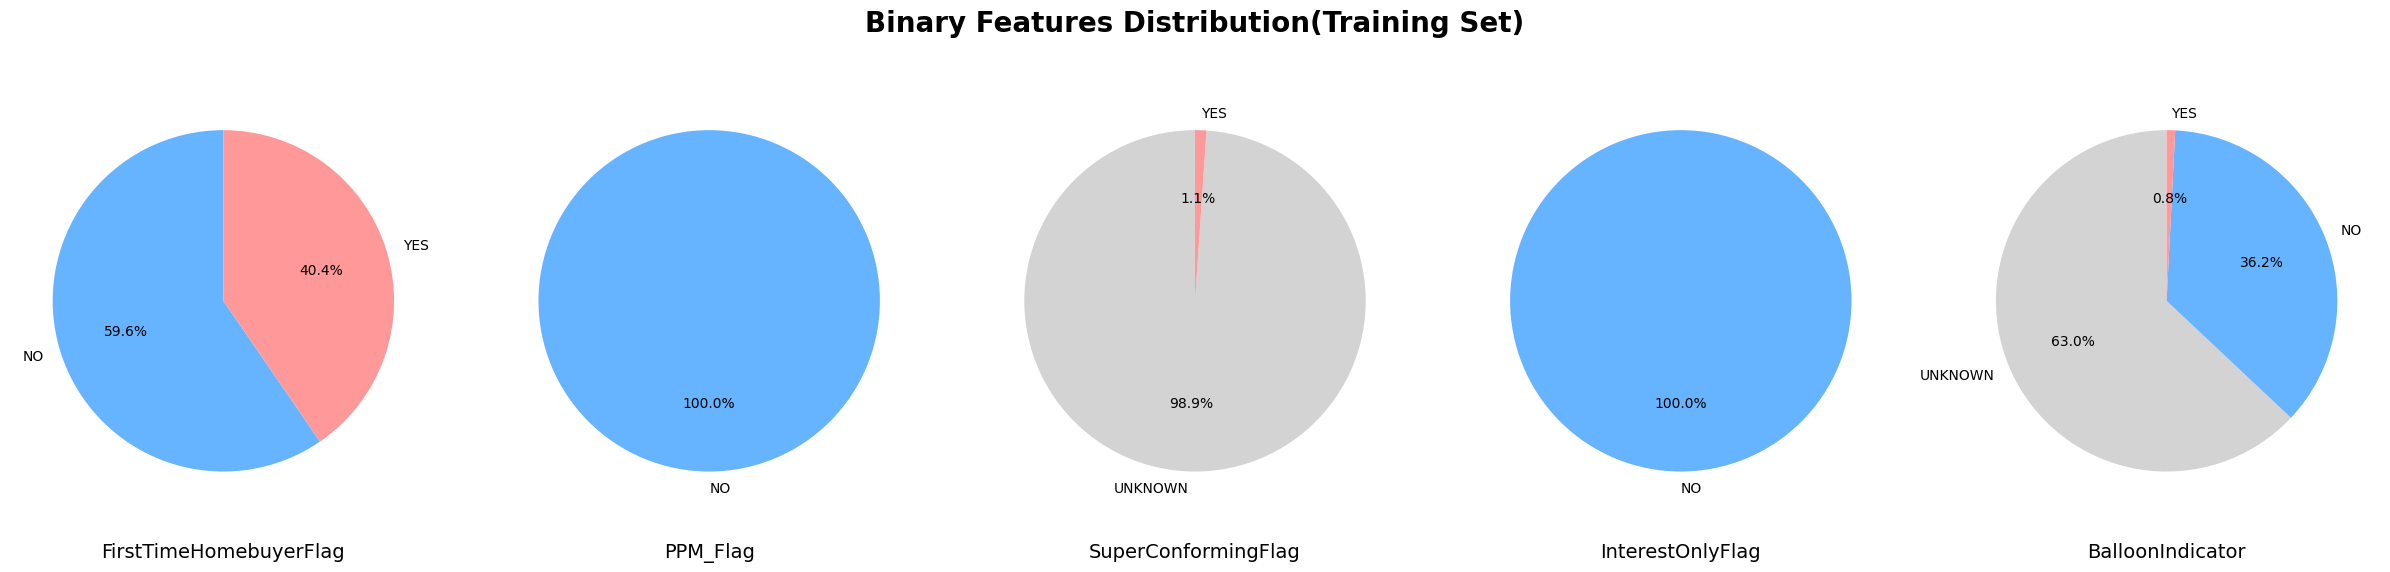

In [27]:
# 2. Pie Chart Visualization for Binary Features

# Create subplots for pie charts - 2 rows (training, validation) x 3 columns
fig, axes = plt.subplots(1, 5, figsize=(24, 6))

# Define consistent color mapping for specific values
value_color_map = {
    0: '#66b3ff',    # Blue for False/N
    1: '#ff9999',    # Red for True/Y
    -1: '#d3d3d3',   # Orange for Unknown/7
}

binary_label_map = {
    0: 'NO',
    1: 'YES',
    -1: 'UNKNOWN'
}

# Plot training data (first row)
for i, feature in enumerate(binary_features):
    if i < 5:  # First row
        # Get value counts for training data
        value_counts_train = df[feature].value_counts(dropna=False)
        
        # Create color list and readable labels based on consistent mapping
        pie_colors = []
        readable_labels = []
        for value in value_counts_train.index:
            if value in value_color_map:
                pie_colors.append(value_color_map[value])
            else:
                # Fallback color for unexpected values
                pie_colors.append('#c2c2f0')
            
            # Use binary_label_map for readable labels
            if value in binary_label_map:
                readable_labels.append(binary_label_map[value])
            else:
                readable_labels.append(str(value))
        
        # Create pie chart for training data
        wedges, texts, autotexts = axes[i].pie(
            value_counts_train.values, 
            labels=readable_labels,
            autopct='%1.1f%%',
            colors=pie_colors,
            startangle=90,
            textprops={'fontsize': 10}
        )
        
        # Set title for training data at the bottom using xlabel
        axes[i].set_xlabel(f'{feature}', fontsize=14, labelpad=20)

# Add overall title
fig.suptitle('Binary Features Distribution(Training Set)', fontsize=20, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()


Based on the statistical summaries and visualizations, we can drop **PPM_Flag** and **InterestOnlyFlag**, since almost all data points share the same value. **SuperConformingFlag** is also dropped because most of the data points are unavailable(nan).

#### 2.2.2 Distribution in validation set

In [28]:
keep_binary_features = ['FirstTimeHomebuyerFlag', 'BalloonIndicator']

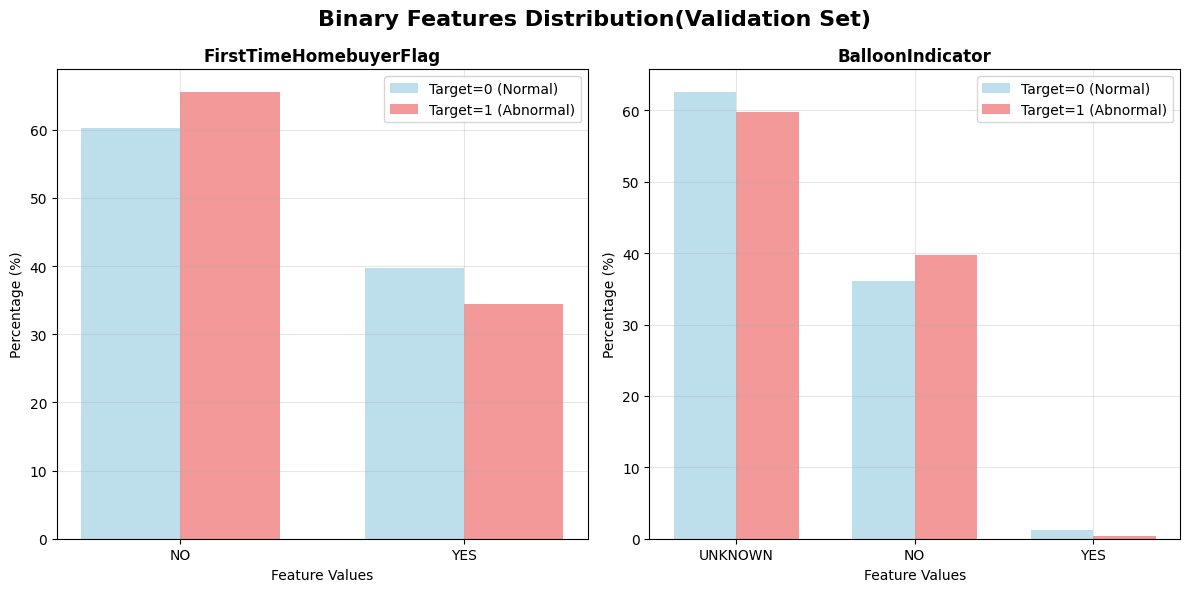

In [30]:
# 3. Bar Chart Visualization for Binary Features with target

n_features = len(keep_binary_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Light red for target=0, light blue for target=1
colors = {'0': '#ff9999', '1': '#66b3ff'}  

for i, feature in enumerate(keep_binary_features):
    if i < len(axes):
        feature_values = df[feature].unique()
        
        # Calculate percentages
        percentages = {}
        target_counts = df_val['target'].value_counts()
        
        for target_val in [0, 1]:
            percentages[target_val] = []
            for feat_val in feature_values:
                # Count: target=t & feature=x
                if type(feat_val) == float:
                    count = len(df_val[(df_val['target'] == target_val) & (df_val[feature].isna())])
                else:
                    count = len(df_val[(df_val['target'] == target_val) & (df_val[feature] == feat_val)])
                # Total: target=t
                total = target_counts[target_val]
                # Percentage
                percentage = (count / total) * 100 if total > 0 else 0
                percentages[target_val].append(percentage)
        
        # Create grouped bar chart
        x = np.arange(len(feature_values))
        width = 0.35
        
        
        bars1 = axes[i].bar(x - width/2, percentages[0], width, 
                           label='Target=0 (Normal)', color='lightblue', alpha=0.8)
        bars2 = axes[i].bar(x + width/2, percentages[1], width, 
                           label='Target=1 (Abnormal)', color='lightcoral', alpha=0.8)
        
        # Customize the plot
        axes[i].set_title(f'{feature}', 
                         fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Feature Values', fontsize=10)
        axes[i].set_ylabel('Percentage (%)', fontsize=10)
        axes[i].set_xticks(x)
        
        # Use binary_label_map for readable labels
        readable_labels = []
        for feat_val in feature_values:
            if feat_val in binary_label_map:
                readable_labels.append(binary_label_map[feat_val])
            else:
                readable_labels.append(str(feat_val))
        
        axes[i].set_xticklabels(readable_labels)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        # for bars in [bars1, bars2]:
        #     for bar in bars:
        #         height = bar.get_height()
        #         if height > 0:  # Only show label if height > 0
        #             axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.5,
        #                         f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Add summary statistics
        total_samples = len(df_val)
        target_0_pct = (target_counts[0] / total_samples) * 100
        target_1_pct = (target_counts[1] / total_samples) * 100
    
# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)
    
fig.suptitle('Binary Features Distribution(Validation Set)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [29]:
# Print detailed statistics for each feature

for feature in keep_binary_features:
    print(f"\n--- {feature} ---")
    
    # Get unique values
    feature_values = df[feature].dropna().unique()
    target_counts = df_val['target'].value_counts()
    
    print(f"Feature values: {list(feature_values)}")
    print(f"Target distribution in validation set: Target=0: {target_counts[0]}, Target=1: {target_counts[1]}")
    
    # Create contingency table
    contingency_table = pd.crosstab(df_val[feature], df_val['target'], margins=True)
    print(f"\nContingency Table:")
    print(contingency_table)
    
    # Calculate percentages
    print(f"\nPercentage Distribution:")
    for target_val in [0, 1]:
        print(f"  Target={target_val}:")
        for feat_val in feature_values:
            count = len(df_val[(df_val['target'] == target_val) & (df_val[feature] == feat_val)])
            total = target_counts[target_val]
            percentage = (count / total) * 100 if total > 0 else 0
            print(f"    {feat_val}: {count}/{total} = {percentage:.2f}%")
    
    print("-" * 50)



--- FirstTimeHomebuyerFlag ---
Feature values: [np.float64(0.0), np.float64(1.0)]
Target distribution in validation set: Target=0: 4693, Target=1: 677

Contingency Table:
target                     0    1   All
FirstTimeHomebuyerFlag                 
0.0                     2827  444  3271
1.0                     1866  233  2099
All                     4693  677  5370

Percentage Distribution:
  Target=0:
    0.0: 2827/4693 = 60.24%
    1.0: 1866/4693 = 39.76%
  Target=1:
    0.0: 444/677 = 65.58%
    1.0: 233/677 = 34.42%
--------------------------------------------------

--- BalloonIndicator ---
Feature values: [np.float64(-1.0), np.float64(0.0), np.float64(1.0)]
Target distribution in validation set: Target=0: 4693, Target=1: 677

Contingency Table:
target               0    1   All
BalloonIndicator                 
-1.0              2939  405  3344
 0.0              1696  269  1965
 1.0                58    3    61
 All              4693  677  5370

Percentage Distribution:
  Tar

**FirstTimeHomebuyerFlag**
- Distribution
    - Normal (target=0): N = 60.2%, Y = 39.8%
    - Anomalous (target=1): N = 65.6%, Y = 34.4%
- Difference: The proportion of N is slightly higher in anomalous samples (+5.3%), while Y is lower.
- Insight: First-time homebuyers appear slightly less likely to be anomalous (i.e., have a lower default rate).

**BalloonIndicator**
- Distribution
    - Unknown (7): Normal = 62.6%, Anomalous = 59.8% (slightly fewer Unknown in anomalous cases)
    - N: Normal = 36.1%, Anomalous = 39.7% (higher proportion of N in anomalous cases)
    - Y: Very small proportion overall; even fewer in anomalous cases
- Insight: The category “N” appears relatively more common among anomalous samples.

### 2.3 Nominal Features

In [14]:
nominal_features = [
    'MSA',                  # null if unknown
    'OccupancyStatus',      # P/I/S. 9-Not Available
    'Channel',              # R/C/B, 9-Not Available
    'ProductType', 
    'PropertyState',        # 2-letter state code
    'PropertyType',         # 99-Not Available
    'PostalCode',           # 5-digit zip code
    'LoanPurpose',          # 9-Not Available
    'SellerName', 
    'ServicerName',
    'ProgramIndicator',     # 9-Not Available
    'ReliefRefinanceIndicator',
    'PreHARP_Flag',
    'PropertyValMethod'
]

In [15]:
nominal_mapping = {
    '9': 'Unknown',
    '99': 'Unknown',
    np.nan: 'Unknown'
}
df[nominal_features] = df[nominal_features].replace(nominal_mapping).fillna('Unknown')
df_val[nominal_features] = df_val[nominal_features].replace(nominal_mapping).fillna('Unknown')

#### 2.3.1 Distribution in Training Set

In [16]:
# 1. Summary
nominal_summary = []
for feature in nominal_features:
    unique_count = df[feature].nunique()
    null_count = (df[feature] == 'Unknown').sum()
    null_pct = (null_count / len(df)) * 100
    dtype = df[feature].dtype
        
    nominal_summary.append({
        'Feature': feature,
        'Data_Type': str(dtype),
        'Unique_Values': unique_count,
        'Null_Count': null_count,
        'Null_Pct': f"{null_pct:.2f}%"
    })
   
# Create summary DataFrame
nominal_df = pd.DataFrame(nominal_summary)
print(f"\nNOMINAL FEATURES SUMMARY:")
print(nominal_df.to_string(index=False))


NOMINAL FEATURES SUMMARY:
                 Feature Data_Type  Unique_Values  Null_Count Null_Pct
                     MSA    object            412        3422   11.22%
         OccupancyStatus    object              3           0    0.00%
                 Channel    object              3           0    0.00%
             ProductType    object              1           0    0.00%
           PropertyState    object             54           0    0.00%
            PropertyType    object              5           0    0.00%
              PostalCode     int64            863           0    0.00%
             LoanPurpose    object              3           0    0.00%
              SellerName    object             20           0    0.00%
            ServicerName    object             19           0    0.00%
        ProgramIndicator    object              3       27115   88.89%
ReliefRefinanceIndicator    object              1       30504  100.00%
            PreHARP_Flag    object              1 

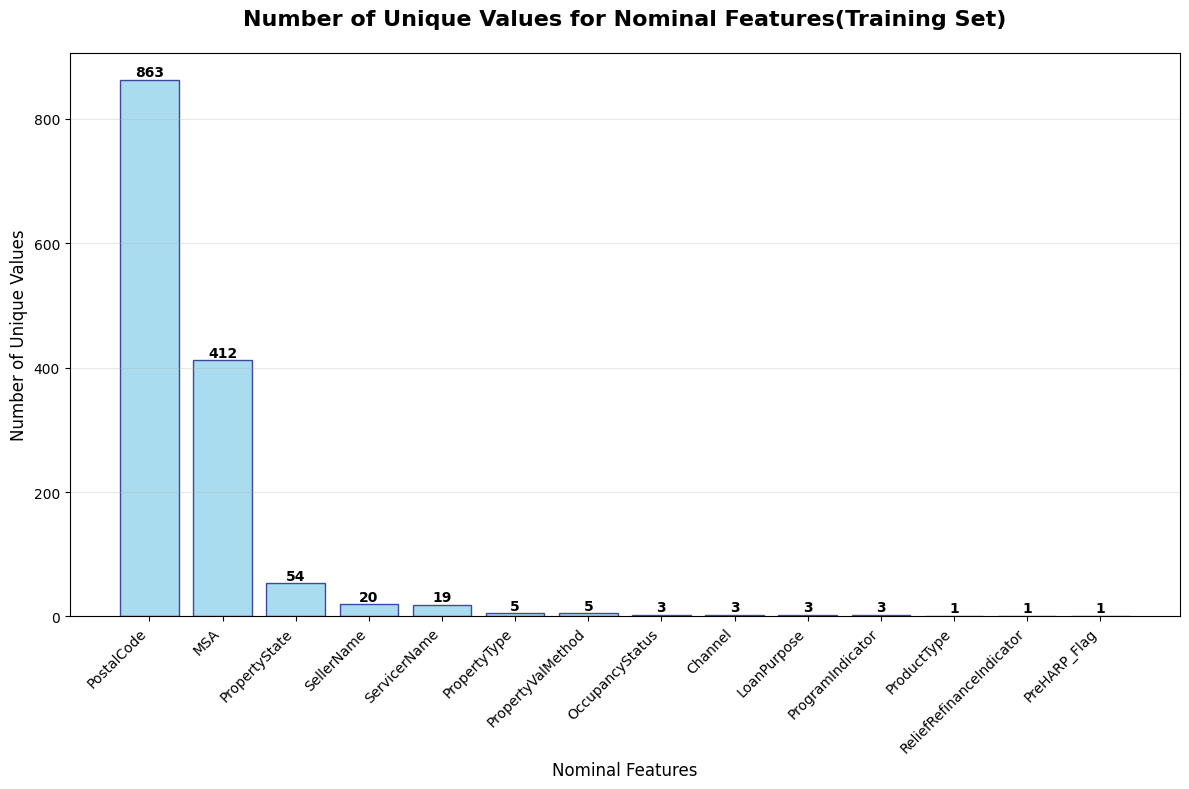

NOMINAL FEATURES UNIQUE VALUE COUNTS (RANKED):
------------------------------------------------------------
Rank Feature                   Unique Values  
------------------------------------------------------------
1    PostalCode                863            
2    MSA                       412            
3    PropertyState             54             
4    SellerName                20             
5    ServicerName              19             
6    PropertyType              5              
7    PropertyValMethod         5              
8    OccupancyStatus           3              
9    Channel                   3              
10   LoanPurpose               3              
11   ProgramIndicator          3              
12   ProductType               1              
13   ReliefRefinanceIndicator  1              
14   PreHARP_Flag              1              


In [18]:
# Bar Chart: Number of Unique Values for Nominal Features (Ranked)

# Calculate unique value counts for each nominal feature
unique_counts = []
feature_names = []

for feature in nominal_features:
    unique_count = df[feature].nunique()
    unique_counts.append(unique_count)
    feature_names.append(feature)

# Sort by unique count (descending order)
sorted_data = sorted(zip(feature_names, unique_counts), key=lambda x: x[1], reverse=True)
sorted_features, sorted_counts = zip(*sorted_data)

# Create bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(sorted_features)), sorted_counts, 
               color='skyblue', alpha=0.7, edgecolor='navy', linewidth=1)

# Customize the chart
plt.title('Number of Unique Values for Nominal Features(Training Set)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Nominal Features', fontsize=12)
plt.ylabel('Number of Unique Values', fontsize=12)

# Set x-axis labels
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha='right')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, sorted_counts)):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add grid for better readability
plt.grid(True, alpha=0.3, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print ranked summary statistics
print("NOMINAL FEATURES UNIQUE VALUE COUNTS (RANKED):")
print("-" * 60)
print(f"{'Rank':<4} {'Feature':<25} {'Unique Values':<15}")
print("-" * 60)
for rank, (feature, count) in enumerate(sorted_data, 1):
    print(f"{rank:<4} {feature:<25} {count:<15}")


As we can see, **ReliefRefinanceIndicator** and **PreHARP_Flag** can be dropped because all the values are null. **ProductType** only has 1 unique value, so we can also drop it.

In [19]:
keep_nominal_features = [col for col in nominal_features if col not in ['ReliefRefinanceIndicator', 'PreHARP_Flag', 'ProductType']]

In [20]:
# Categorize features by cardinality
print(f"\nFEATURES BY CARDINALITY:")
print("-" * 30)

low_cardinality = []    # < 10 unique values
medium_cardinality = [] # 10-50 unique values
high_cardinality = []   # > 50 unique values

for feature in keep_nominal_features:
    if feature in df.columns:
        unique_count = df[feature].nunique()
        if unique_count < 10:
            low_cardinality.append((feature, unique_count))
        elif unique_count <= 50:
            medium_cardinality.append((feature, unique_count))
        else:
            high_cardinality.append((feature, unique_count))

print(f"Low Cardinality (< 10 unique values):")
for feature, count in low_cardinality:
    print(f"  {feature}: {count} unique values")

print(f"\nMedium Cardinality (10-50 unique values):")
for feature, count in medium_cardinality:
    print(f"  {feature}: {count} unique values")

print(f"\nHigh Cardinality (> 50 unique values):")
for feature, count in high_cardinality:
    print(f"  {feature}: {count} unique values")



FEATURES BY CARDINALITY:
------------------------------
Low Cardinality (< 10 unique values):
  OccupancyStatus: 3 unique values
  Channel: 3 unique values
  PropertyType: 5 unique values
  LoanPurpose: 3 unique values
  ProgramIndicator: 3 unique values
  PropertyValMethod: 5 unique values

Medium Cardinality (10-50 unique values):
  SellerName: 20 unique values
  ServicerName: 19 unique values

High Cardinality (> 50 unique values):
  MSA: 412 unique values
  PropertyState: 54 unique values
  PostalCode: 863 unique values


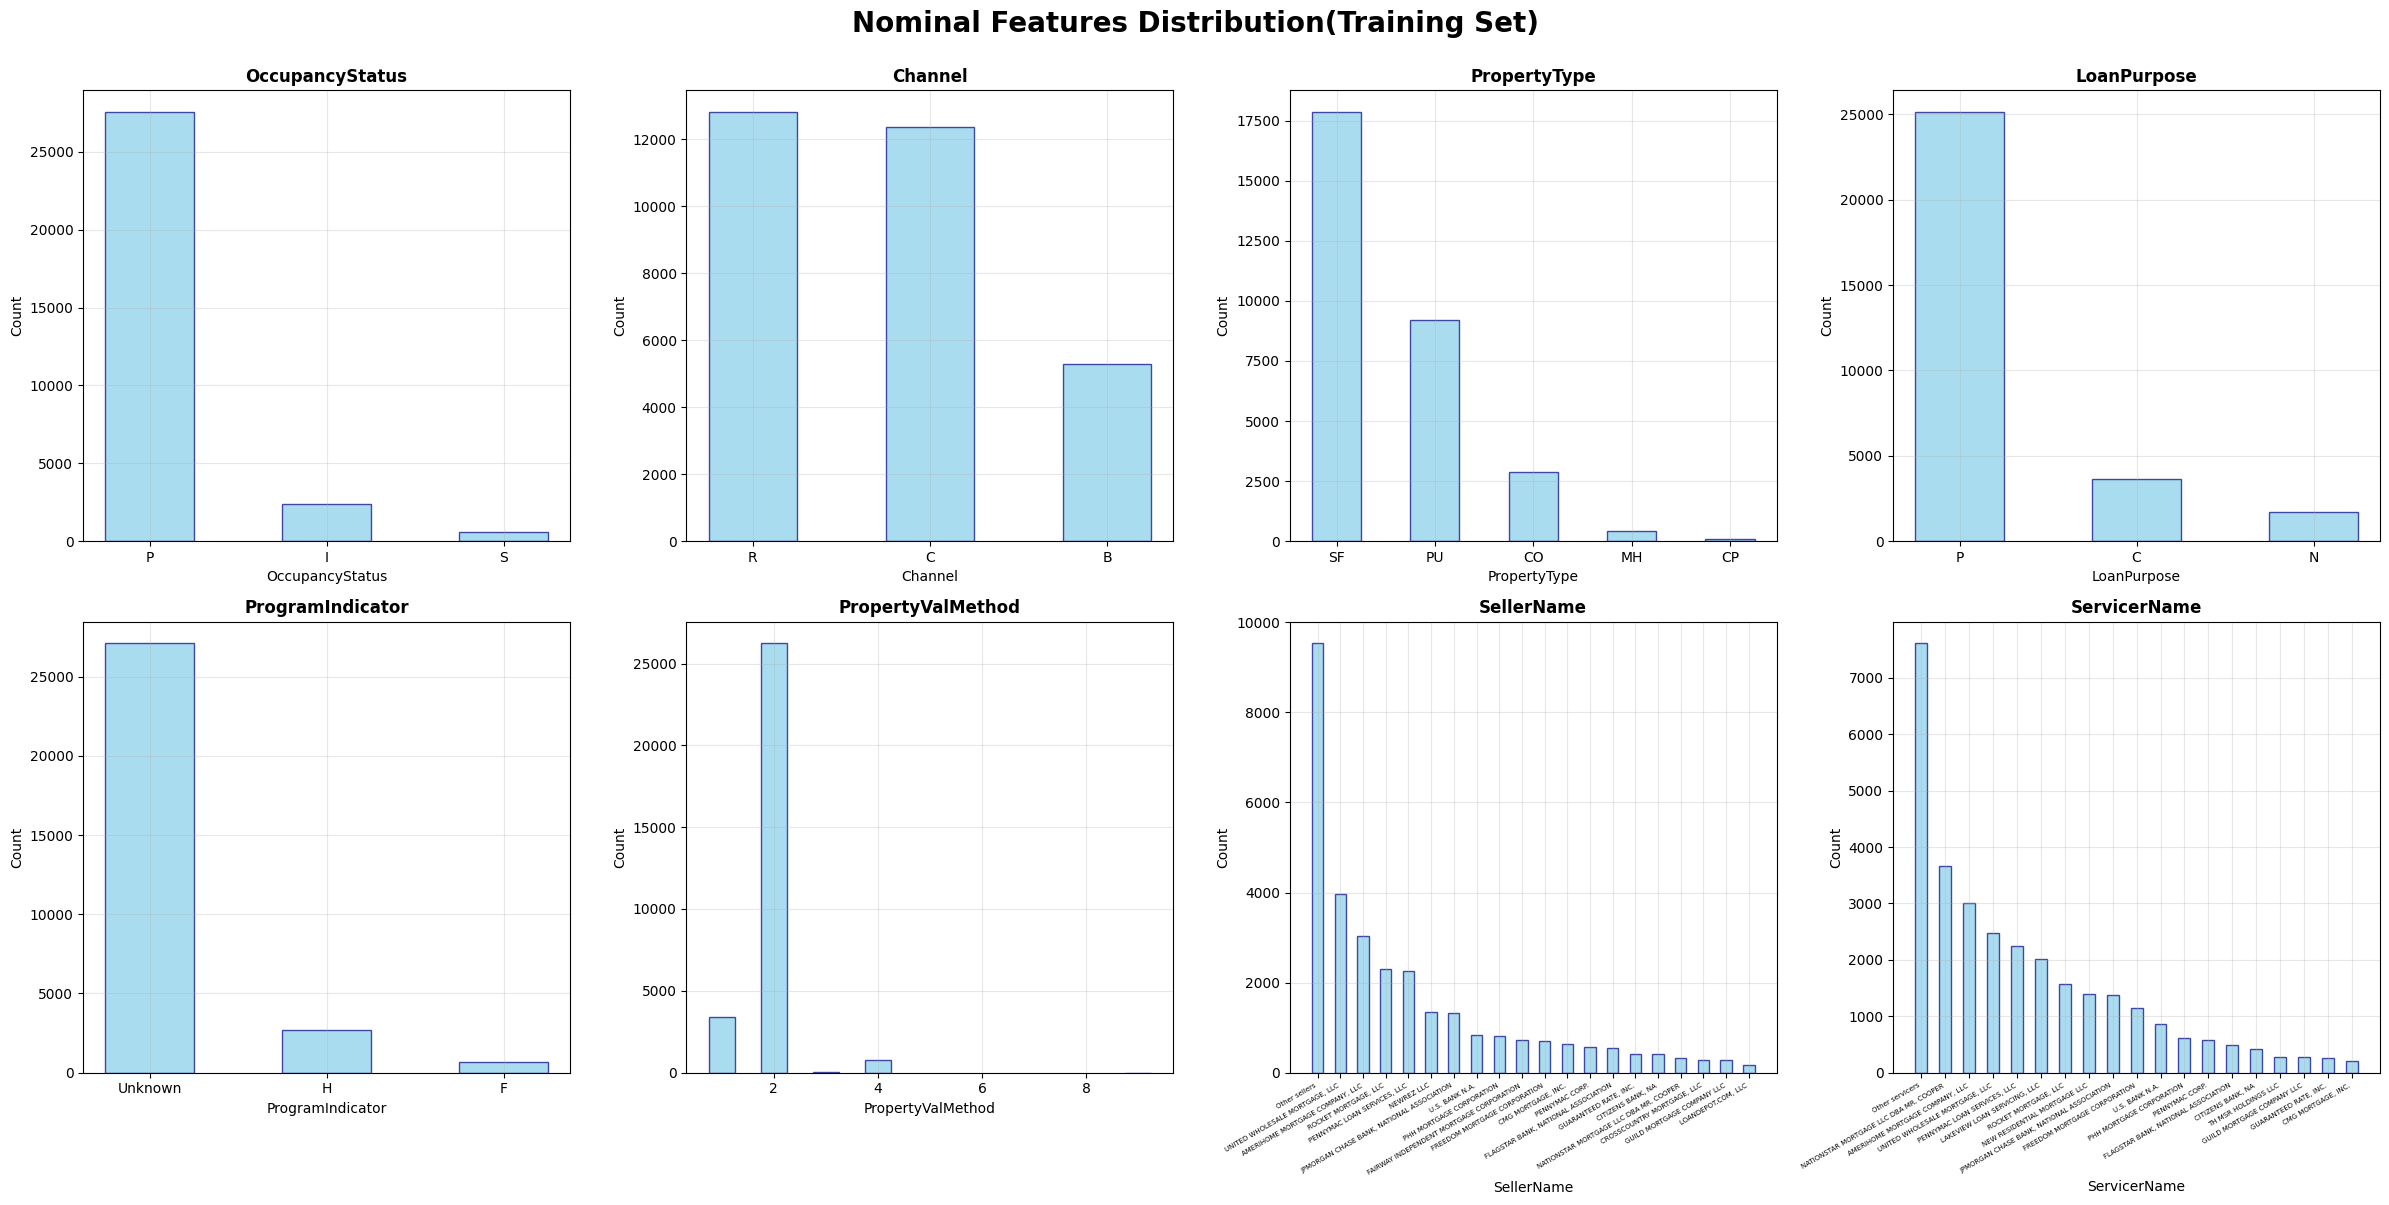

In [21]:
# 2. Bar Chart Visualization for Nominal Features

nominal_features = low_cardinality + medium_cardinality
nominal_features = [col[0] for col in nominal_features]

# Create subplots for bar charts
n_features = len(nominal_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, feature in enumerate(nominal_features):
    if i < len(axes):
        value_counts = df[feature].value_counts(dropna=False)
        total_count = len(df)
        
        # Create bar chart
        bars = axes[i].bar(value_counts.index, value_counts.values, alpha=0.7, color='skyblue', edgecolor='navy', width=0.5)
        axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=10)
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        
        if feature in ['PropertyState', 'SellerName', 'ServicerName']:
            axes[i].set_xticks(value_counts.index)
            axes[i].set_xticklabels(value_counts.index, fontsize=5,rotation=30, ha='right')
        
        # Add value labels on bars
        # for bar, count in zip(bars, value_counts.values):
        #     axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(value_counts.values),
        #                 str(count), ha='center', va='bottom', fontsize=10)

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Title
fig.suptitle('Nominal Features Distribution(Training Set)', fontsize=20, fontweight='bold', y=1)

plt.tight_layout()
plt.show()

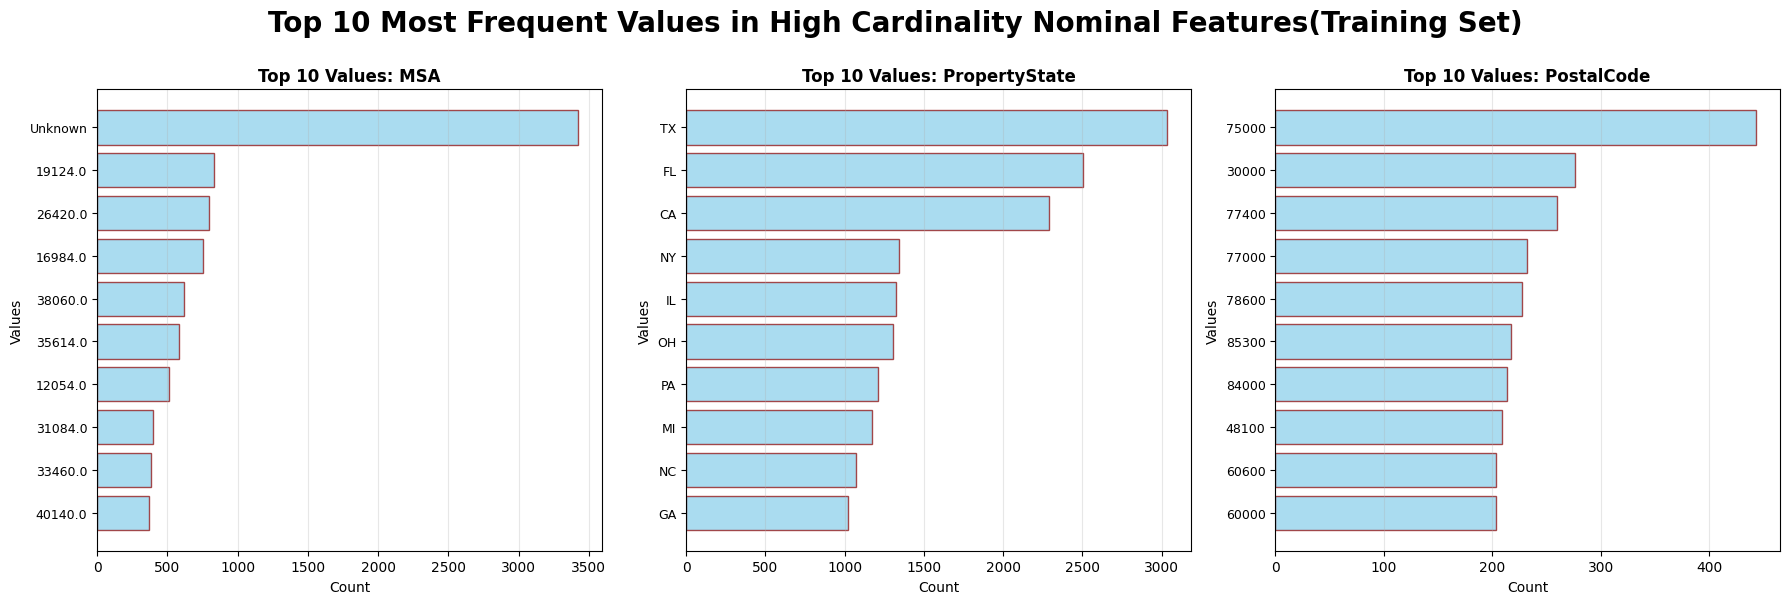

TOP 10 VALUES FOR HIGH CARDINALITY FEATURES:

MSA:
------------------------------
  Unknown        :   3422 ( 11.2%)
  19124.0        :    829 (  2.7%)
  26420.0        :    795 (  2.6%)
  16984.0        :    756 (  2.5%)
  38060.0        :    616 (  2.0%)
  35614.0        :    581 (  1.9%)
  12054.0        :    508 (  1.7%)
  31084.0        :    398 (  1.3%)
  33460.0        :    381 (  1.2%)
  40140.0        :    366 (  1.2%)

PropertyState:
------------------------------
  TX             :   3034 (  9.9%)
  FL             :   2505 (  8.2%)
  CA             :   2287 (  7.5%)
  NY             :   1341 (  4.4%)
  IL             :   1321 (  4.3%)
  OH             :   1304 (  4.3%)
  PA             :   1209 (  4.0%)
  MI             :   1173 (  3.8%)
  NC             :   1074 (  3.5%)
  GA             :   1024 (  3.4%)

PostalCode:
------------------------------
  75000          :    443 (  1.5%)
  30000          :    276 (  0.9%)
  77400          :    260 (  0.9%)
  77000          :    

In [22]:
# Top 10 Values for High Cardinality Features

# Define high cardinality features (> 50 unique values)
high_cardinality_features = [col[0] for col in high_cardinality]

# Create subplots for each high cardinality feature
n_features = len(high_cardinality_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, feature in enumerate(high_cardinality_features):
    if i < len(axes):
        # Get top 10 most frequent values
        top_10 = df[feature].value_counts().head(10)
        
        # Create horizontal bar chart for better readability
        bars = axes[i].barh(range(len(top_10)), top_10.values, 
                           color='skyblue', alpha=0.7, edgecolor='darkred', linewidth=1)
        
        # Customize the plot
        axes[i].set_title(f'Top 10 Values: {feature}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Count', fontsize=10)
        axes[i].set_ylabel('Values', fontsize=10)
        axes[i].set_yticks(range(len(top_10)))
        axes[i].set_yticklabels(top_10.index, fontsize=9)
        axes[i].grid(True, alpha=0.3, axis='x')
        
        # Add value labels on bars
        # for j, (bar, count) in enumerate(zip(bars, top_10.values)):
        #     axes[i].text(bar.get_width() + 0.01*max(top_10.values), bar.get_y() + bar.get_height()/2,
        #                 str(count), ha='left', va='center', fontsize=9, fontweight='bold')
        
        # Invert y-axis to show highest values at top
        axes[i].invert_yaxis()

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Add overall title
fig.suptitle('Top 10 Most Frequent Values in High Cardinality Nominal Features(Training Set)', 
             fontsize=20, fontweight='bold', y=1)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("TOP 10 VALUES FOR HIGH CARDINALITY FEATURES:")
print("=" * 60)
for feature in high_cardinality_features:
    print(f"\n{feature}:")
    print("-" * 30)
    top_10 = df[feature].value_counts().head(10)
    total_count = len(df)
    for value, count in top_10.items():
        percentage = (count / total_count) * 100
        print(f"  {str(value):<15}: {count:>6} ({percentage:>5.1f}%)")


#### 2.3.2 Distribution in Validation Set

In [65]:
low_cardinality_features = ['OccupancyStatus', 'Channel', 'PropertyType', 'LoanPurpose', 'ProgramIndicator', 'PropertyValMethod']
medium_cardinality_features = ['SellerName', 'ServicerName']  # 54 unique values
high_cardinality_features = ['MSA', 'PostalCode', 'PropertyState']

In [69]:
all_features = low_cardinality_features + medium_cardinality_features + high_cardinality_features
print(len(all_features))

11


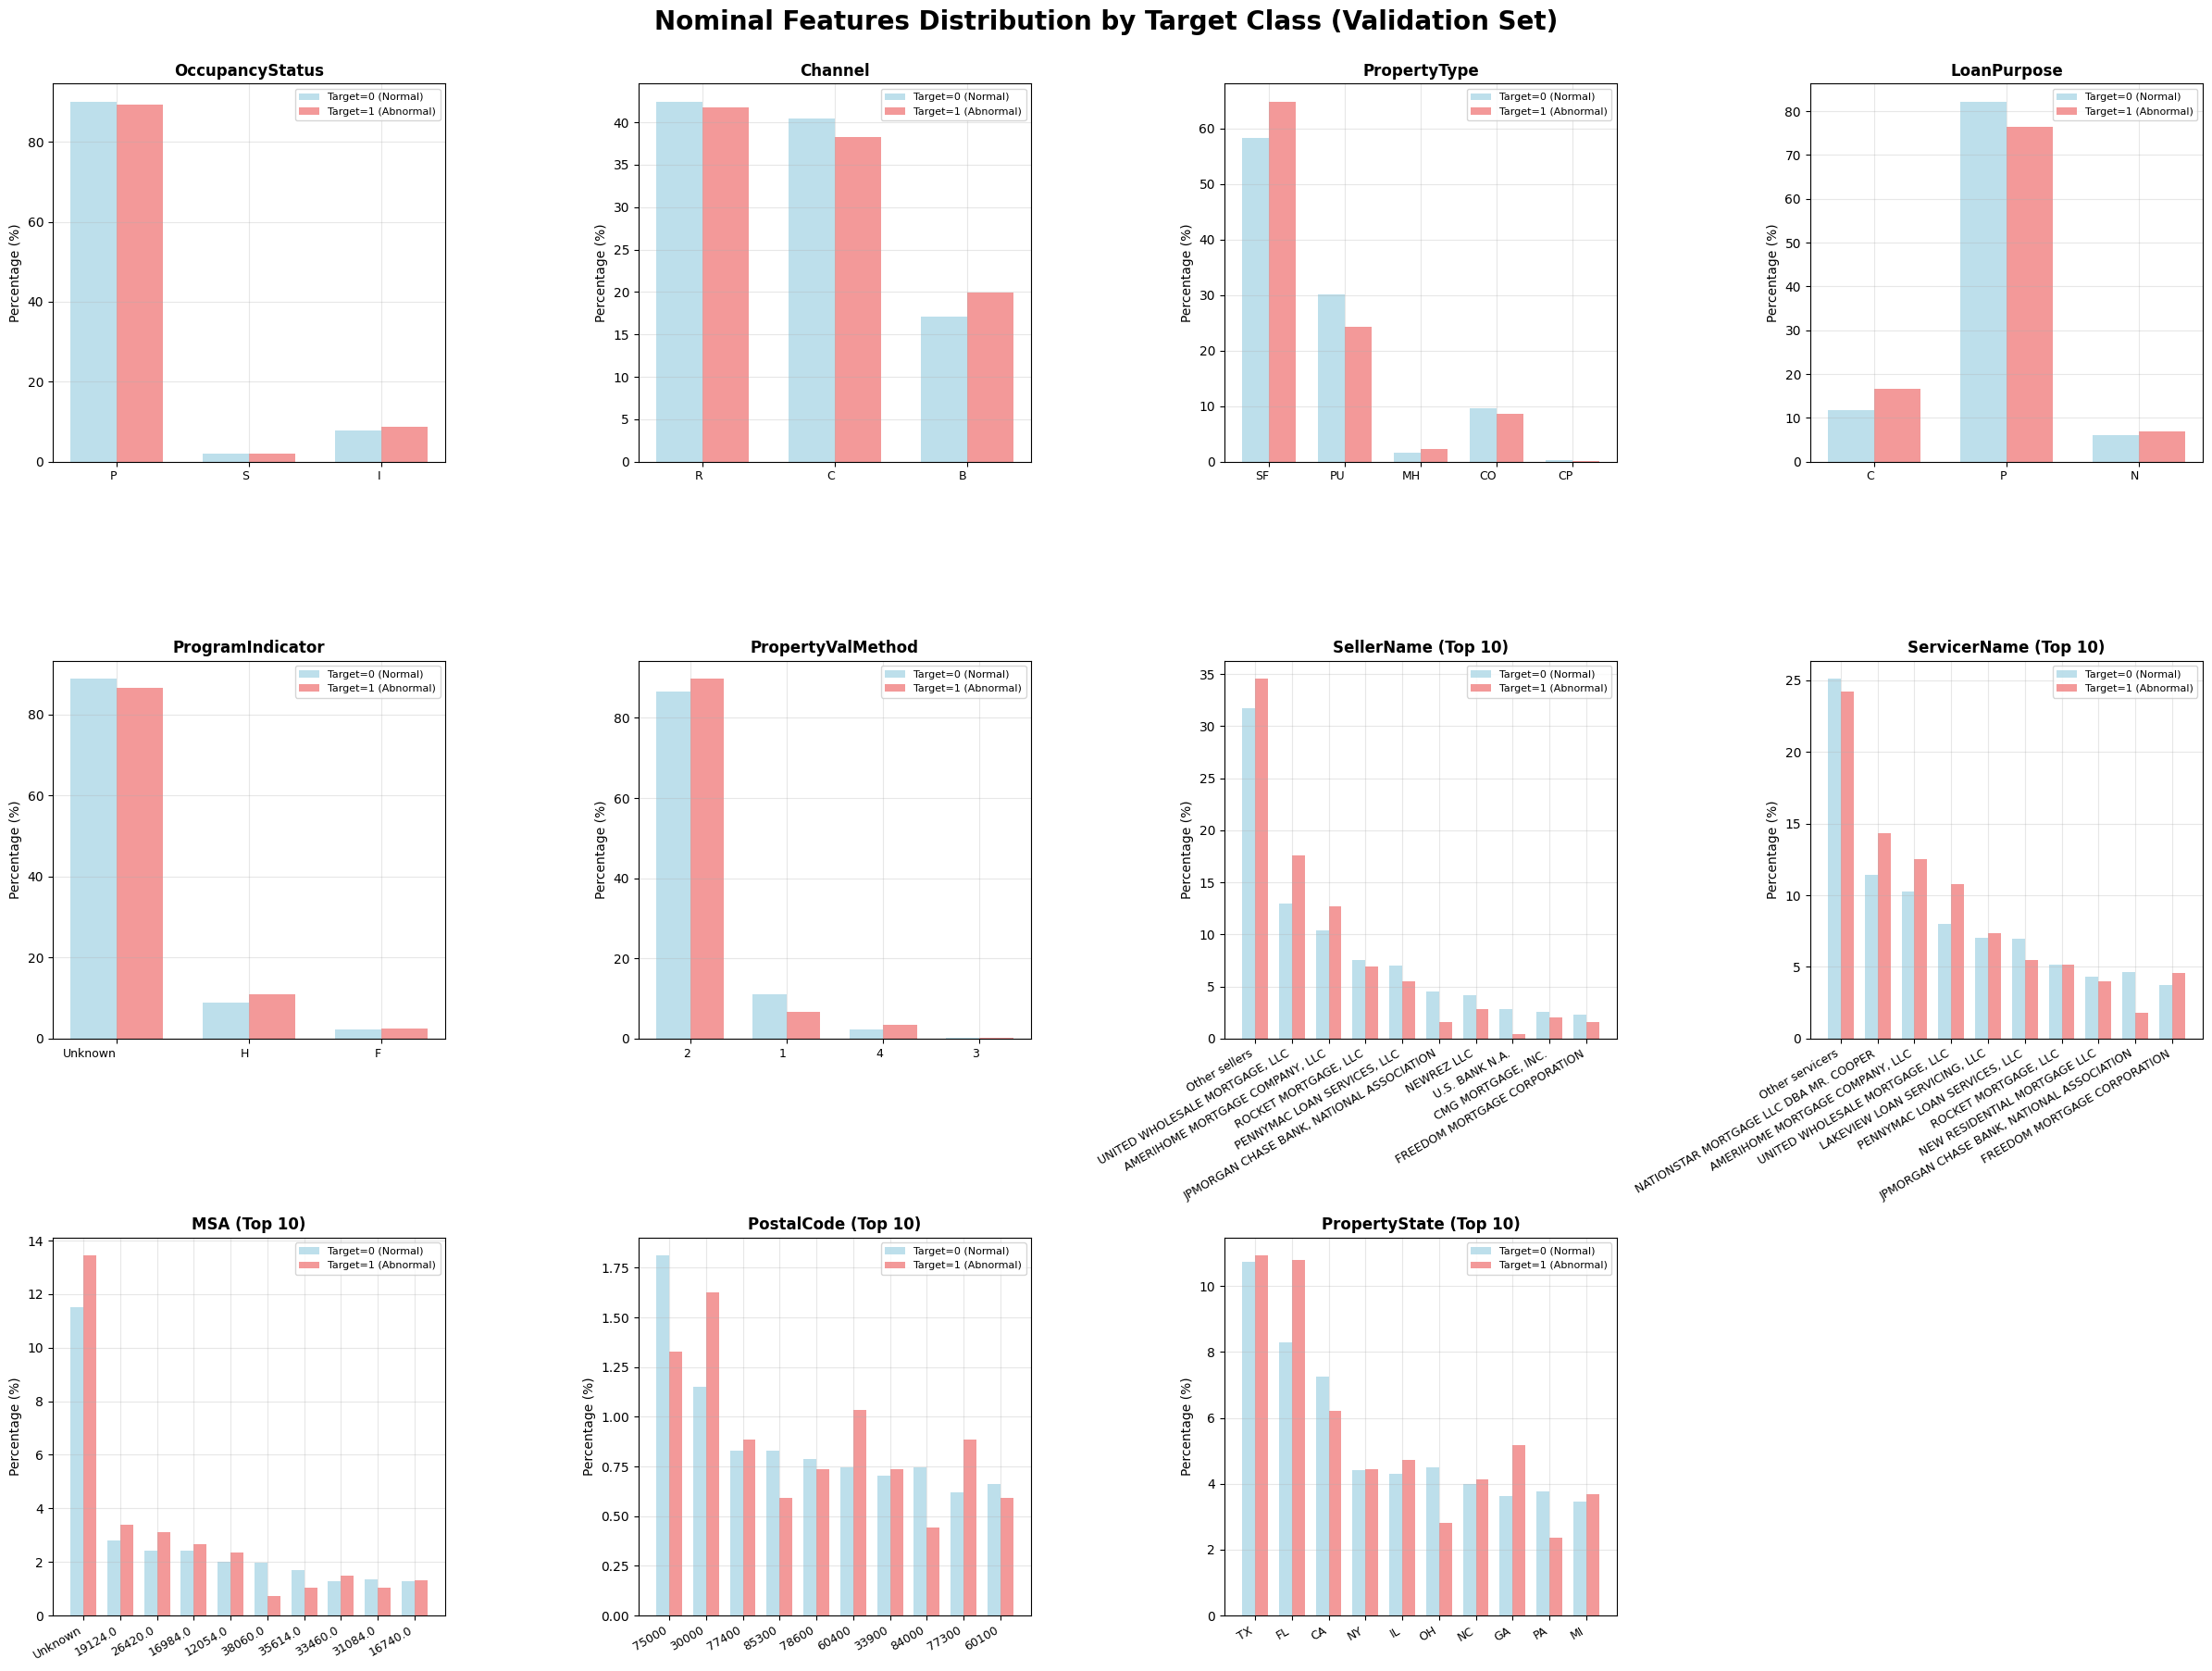

In [79]:
n_features = len(all_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Updated function to show top 10 for features with >10 values
def create_feature_plot_updated(ax, feature, title):
    target_0_counts = df_val[df_val['target'] == 0][feature].value_counts()
    target_1_counts = df_val[df_val['target'] == 1][feature].value_counts()
    
    all_values = df_val[feature].unique()
    
    # If more than 10 values, show only top 10
    if len(all_values) > 10:
        top_10_values = df_val[feature].value_counts().head(10).index
        values_to_show = top_10_values
        title_suffix = " (Top 10)"
    else:
        values_to_show = all_values
        title_suffix = ""
    
    # Ensure both series have the same index for values we're showing
    target_0_counts = target_0_counts.reindex(values_to_show, fill_value=0)
    target_1_counts = target_1_counts.reindex(values_to_show, fill_value=0)
    
    total_0 = len(df_val[df_val['target'] == 0])
    total_1 = len(df_val[df_val['target'] == 1])
    target_0_pct = (target_0_counts / total_0) * 100
    target_1_pct = (target_1_counts / total_1) * 100
    
    x = np.arange(len(values_to_show))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, target_0_pct, width, 
                   label='Target=0 (Normal)', color='lightblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, target_1_pct, width, 
                   label='Target=1 (Abnormal)', color='lightcoral', alpha=0.8)
    
    ax.set_title(f'{title}{title_suffix}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.set_xticks(x)
    if len(values_to_show) == 10:
        ax.set_xticklabels(values_to_show, rotation=30, ha='right', fontsize=9)
    else:
        ax.set_xticklabels(values_to_show, rotation=0, ha='right', fontsize=9)
    
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    return bars1, bars2

for i, feature in enumerate(all_features):
    if i < len(axes):
        create_feature_plot_updated(axes[i], feature, f'{feature}')

for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

fig.suptitle('Nominal Features Distribution by Target Class (Validation Set)', 
             fontsize=20, fontweight='bold', y=1)

plt.tight_layout()
plt.show()


In [91]:
# DETAILED FEATURE ANALYSIS

summary_table = []

for feature in all_features:
    
    target_0_counts = df_val[df_val['target'] == 0][feature].value_counts()
    target_1_counts = df_val[df_val['target'] == 1][feature].value_counts()
    
    total_0 = len(df_val[df_val['target'] == 0])
    total_1 = len(df_val[df_val['target'] == 1])
    
    # Show top 10 for features with >10 values, all values otherwise
    if len(df_val[feature].unique()) > 10:
        values_to_show = df_val[feature].value_counts().head(10)
    else:
        values_to_show = df_val[feature].value_counts()
    
    for value in values_to_show.index:
        count_0 = target_0_counts.get(value, 0)
        count_1 = target_1_counts.get(value, 0)
        pct_0 = (count_0 / total_0) * 100
        pct_1 = (count_1 / total_1) * 100
        
        # Calculate risk ratio (higher ratio = more associated with abnormal loans)
        risk_ratio = pct_1 / pct_0 if pct_0 > 0 else float('inf')
   
        # Add to summary table for DataFrame
        summary_table.append({
            'Feature': feature,
            'Value': str(value),
            'Target_0_Pct': round(pct_0, 2),
            'Target_1_Pct': round(pct_1, 2),
            'Risk_Ratio': round(risk_ratio, 2) if risk_ratio != float('inf') else 'inf'
        })

# Create DataFrame from summary table
summary_df = pd.DataFrame(summary_table)

In [92]:
summary_df[(summary_df['Risk_Ratio'] < 0.8) | (summary_df['Risk_Ratio'] > 1.2)]

,Feature,Value,Target_0_Pct,Target_1_Pct,Risk_Ratio
9,PropertyType,MH,1.56,2.22,1.42
10,PropertyType,CP,0.26,0.15,0.58
12,LoanPurpose,C,11.78,16.69,1.42
15,ProgramIndicator,H,8.93,10.93,1.22
18,PropertyValMethod,1,11.08,6.65,0.60
19,PropertyValMethod,4,2.17,3.40,1.56
20,PropertyValMethod,3,0.23,0.15,0.63
22,SellerName,"UNITED WHOLESALE MORTGAGE, LLC",12.96,17.58,1.36
23,SellerName,"AMERIHOME MORTGAGE COMPANY, LLC",10.38,12.70,1.22
25,SellerName,"PENNYMAC LOAN SERVICES, LLC",6.99,5.47,0.78


- **PropertyType**
    - Distribution
        - Manufactured Home (MH): Higher in anomalous cases (2.2% vs. 1.6%, RR = 1.42).
        - Co-op(CP): Lower in anomalous cases(0.26% → 0.15%，RR=0.58).
    - Insights
        - Manufactured Homes are linked to higher anomaly rates, consistent with their lower collateral stability and potentially riskier borrower profiles. 
        - In contrast, Co-ops show lower anomaly rates, which may reflect stricter ownership requirements or stronger borrower screening processes.
- **LoanPurpose**
    - Distribution
        - Cash-out Refinance (C): Significantly higher in anomalous cases (16.7% vs. 11.8%, RR = 1.42).
    - Insight
        - Borrowers taking cash-out refinance loans are more prone to anomalies, likely because they increase leverage or use funds for non-housing purposes, which raises repayment risk.
- **ProgramIndicator**
    - Distribution
        - H: Higher in anomalous cases (8.9% vs. 10.9%, RR = 1.22).
    - Insights
        - Participation in the HARP program is modestly associated with higher anomaly rates. This may reflect the fact that HARP targets borrowers needing refinancing assistance, who could already be at elevated credit risk.
- **PropertyValMethod**
    - Distribution
        - Method 4 (ACE + PDR): Higher in anomalous cases (3.4% vs. 2.2%, RR = 1.56).
        - Method 1 (ACE): Lower in anomalous cases (6.6% vs. 11.1%, RR = 0.60).
        - Method 3 (Other-Desktop/AVM): Lower in anomalous cases (0.23% vs. 0.15%, RR = 0.63).
    - Insights
        - Loans evaluated with ACE + PDR show a higher anomaly rate, possibly indicating that this combined valuation method is applied in riskier cases or when property characteristics are more uncertain. 
        - By contrast, loans assessed using ACE alone or other desktop/AVM methods are linked to lower anomaly rates, suggesting that straightforward automated valuations may be associated with safer, more standard loans.
- **SellerName / ServicerName**
    - Distribution
        - UNITED WHOLESALE and AMERIHOME show higher anomaly rates
        - JPMorgan and U.S. Bank have significantly lower anomaly rates (safer)
    - Insights
        - Lender/servicer identity has clear discriminative power. Some institutions are systematically linked with higher anomaly rates, while others are consistently safer. This likely reflects differences in underwriting standards, borrower pools, and risk management practices.
- Region-Related Features: **MSA / PostalCode / State**
    - Distribution
        - MSA/PostalCode: Certain MSA/codes appear more often in anomalous cases, while others are less common.
        - State: FL (RR = 1.30) and GA (RR = 1.43) show higher anomaly rates, whereas OH(RR=0.62) and PA(RR=0.63) appear safer.
    - Insights:
        - Regional features may offer weak but meaningful predictive signals, as they can indirectly reflect financial or socioeconomic conditions. 




### 2.4 Numeric Features

In [11]:
static_numeric_features = [
    'CreditScore',  # 300-850, 9999=missing/outside range
    'MI_Pct',       # 1-55, 0=none, 999=not available
    'OriginalCLTV',
    'OriginalDTI',  # 999=missing
    'OriginalUPB',
    'OriginalLTV',  # 999=invalid
    'OriginalInterestRate',
    'NumberOfBorrowers',
    'NumberOfUnits',
    'OriginalLoanTerm'
]

In [12]:
# Preprocessing

numeric_features_mapping = {
    999: np.nan,
    9999: np.nan
}
df[static_numeric_features] = df[static_numeric_features].replace(numeric_features_mapping)
df_val[static_numeric_features] = df_val[static_numeric_features].replace(numeric_features_mapping)

#### 2.4.1 Distribution in Training set

In [10]:
# 1. BASIC STATISTICS
stats_data = []

for feature in static_numeric_features:
    if feature in df.columns:
        series = df[feature]
        
        stats_data.append({
            'Feature': feature,
            'Count': series.count(),
            'Missing': series.isnull().sum(),
            'Missing_Pct': f"{(series.isnull().sum() / len(df)) * 100:.2f}%",
            'Mean': f"{series.mean():.2f}",
            'Median': f"{series.median():.2f}",
            'Std': f"{series.std():.2f}",
            'Min': f"{series.min():.2f}",
            'Max': f"{series.max():.2f}",
            'Q1': f"{series.quantile(0.25):.2f}",
            'Q3': f"{series.quantile(0.75):.2f}",
            'Skewness': f"{series.skew():.3f}",
            'Kurtosis': f"{series.kurtosis():.3f}"
        })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))



             Feature  Count  Missing Missing_Pct      Mean    Median       Std      Min        Max        Q1        Q3 Skewness Kurtosis
         CreditScore  30496        8       0.03%    751.13    760.00     43.90   600.00     830.00    723.00    786.00   -0.727   -0.167
              MI_Pct  30504        0       0.00%      9.71      0.00     13.22     0.00      35.00      0.00     25.00    0.733   -1.309
        OriginalCLTV  30504        0       0.00%     75.43     80.00     19.58     6.00     105.00     66.00     90.00   -1.061    0.586
         OriginalDTI  30503        1       0.00%     37.80     40.00      9.32     2.00      50.00     32.00     45.00   -0.713   -0.179
         OriginalUPB  30504        0       0.00% 317095.43 277000.00 181297.52 15000.00 1700000.00 181000.00 415000.00    1.075    1.345
         OriginalLTV  30504        0       0.00%     75.19     80.00     19.43     6.00      97.00     66.00     90.00   -1.086    0.618
OriginalInterestRate  30504        0     

In [11]:
# Identify features with high skewness or kurtosis
print(f"\nFEATURE CHARACTERISTICS:")
print("-" * 30)

for _, row in stats_df.iterrows():
    feature = row['Feature']
    skewness = float(row['Skewness'])
    kurtosis = float(row['Kurtosis'])
    
    characteristics = []
    if abs(skewness) > 1:
        characteristics.append(f"Highly skewed ({'right' if skewness > 0 else 'left'})")
    if abs(kurtosis) > 3:
        characteristics.append("Heavy-tailed")
    
    if characteristics:
        print(f"  {feature}: {', '.join(characteristics)}")
    else:
        print(f"  {feature}: Normal distribution")



FEATURE CHARACTERISTICS:
------------------------------
  CreditScore: Normal distribution
  MI_Pct: Normal distribution
  OriginalCLTV: Highly skewed (left)
  OriginalDTI: Normal distribution
  OriginalUPB: Highly skewed (right)
  OriginalLTV: Highly skewed (left)
  OriginalInterestRate: Normal distribution
  NumberOfBorrowers: Normal distribution
  NumberOfUnits: Highly skewed (right), Heavy-tailed
  OriginalLoanTerm: Highly skewed (left), Heavy-tailed


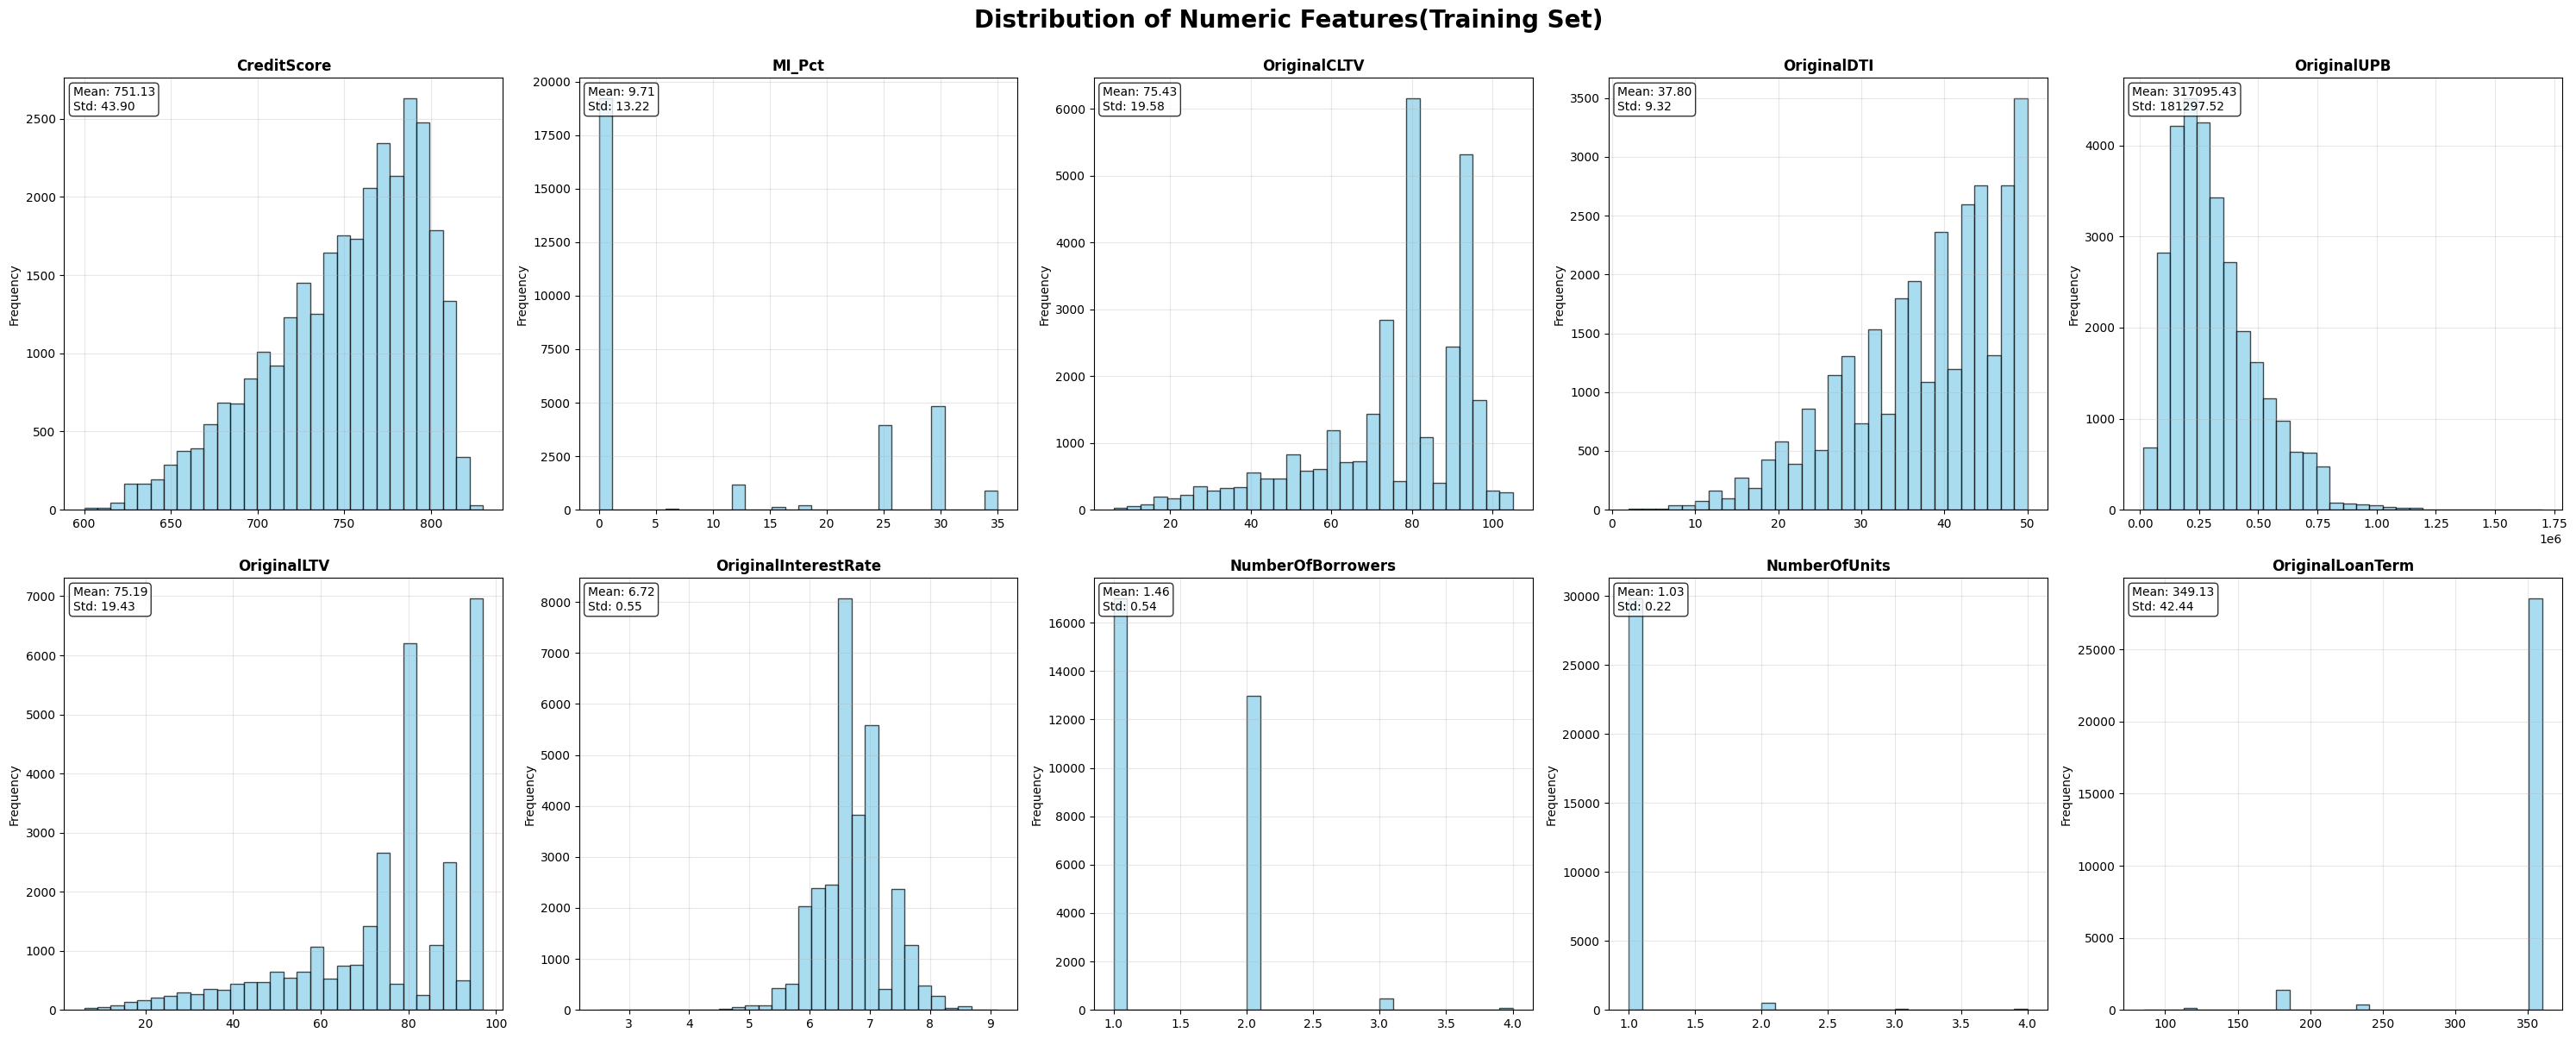

In [13]:
# 2. DISTRIBUTION VISUALIZATION FOR STATIC NUMERIC FEATURES

# Create subplots for histograms and box plots
n_features = len(static_numeric_features)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, feature in enumerate(static_numeric_features):
    if i < len(axes):
        # Create histogram
        axes[i].hist(df[feature].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics text
        mean_val = df[feature].mean()
        std_val = df[feature].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Title
fig.suptitle('Distribution of Numeric Features(Training Set)', 
             fontsize=20, fontweight='bold', y=1)

plt.tight_layout()
plt.show()

#### 2.4.2 Distribution in Validation Set

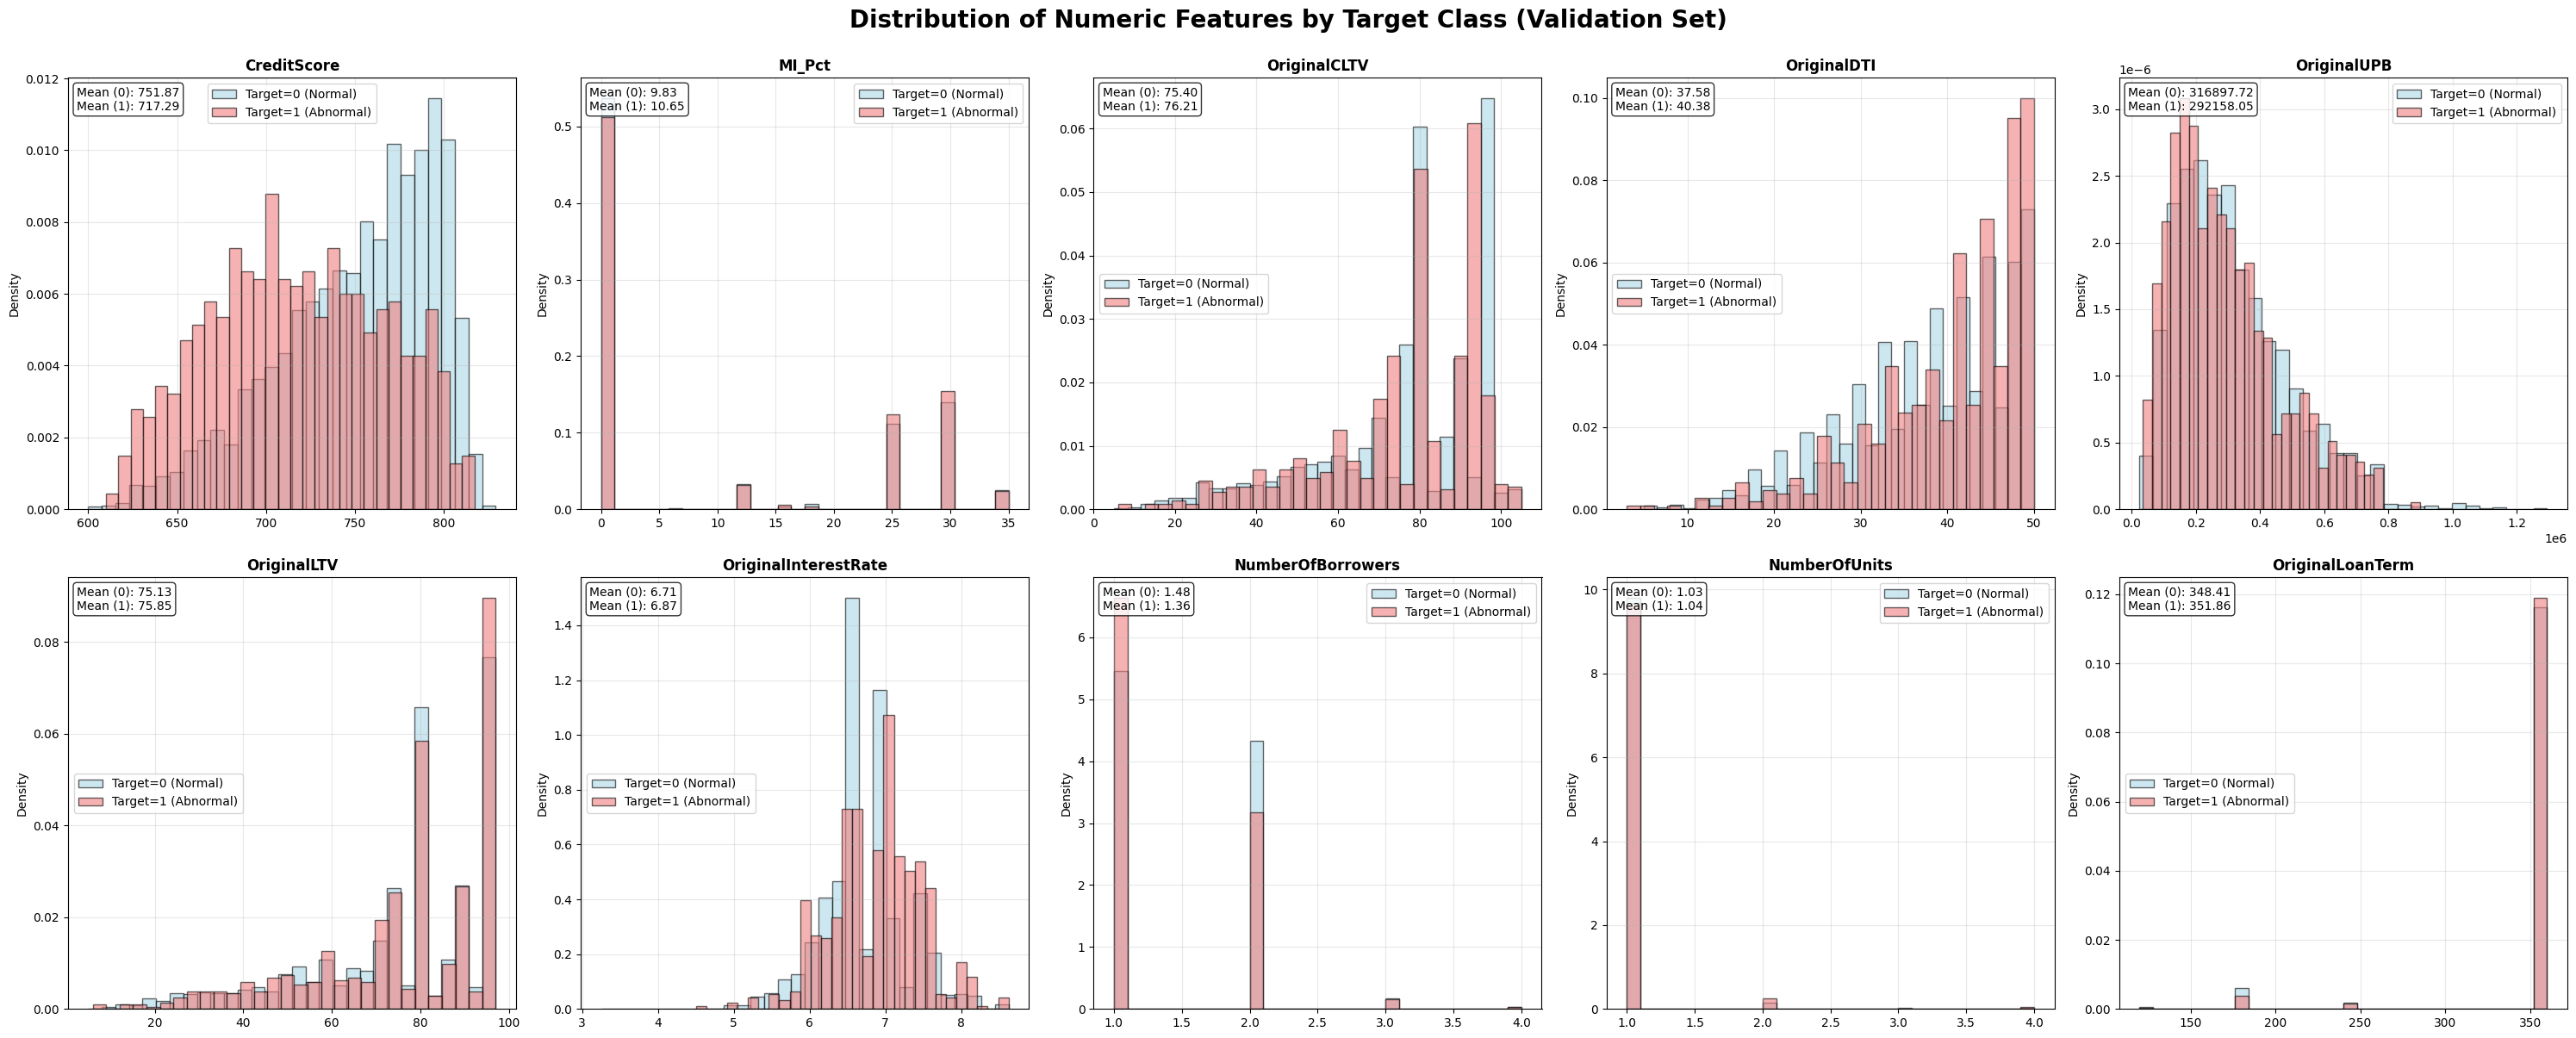

In [18]:
# 1. OVERLAPPING HISTOGRAMS FOR NUMERIC FEATURES BY TARGET CLASS

# Create subplots for overlapping histograms
n_features = len(static_numeric_features)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, feature in enumerate(static_numeric_features):
    if i < len(axes):
        # Get data for each target class
        target_0_data = df_val[df_val['target'] == 0][feature].dropna()
        target_1_data = df_val[df_val['target'] == 1][feature].dropna()
        
        # Create overlapping histograms
        axes[i].hist(target_0_data, bins=30, alpha=0.6, color='lightblue', 
                    label='Target=0 (Normal)', density=True, edgecolor='black')
        axes[i].hist(target_1_data, bins=30, alpha=0.6, color='lightcoral', 
                    label='Target=1 (Abnormal)', density=True, edgecolor='black')
        
        axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Density', fontsize=10)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics text
        mean_0 = target_0_data.mean()
        mean_1 = target_1_data.mean()
        axes[i].text(0.02, 0.98, f'Mean (0): {mean_0:.2f}\nMean (1): {mean_1:.2f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Title
fig.suptitle('Distribution of Numeric Features by Target Class (Validation Set)', 
             fontsize=20, fontweight='bold', y=1)

plt.tight_layout()
plt.show()


In [ ]:
# 2. STATISTICAL SUMMARY COMPARISON BETWEEN TARGET CLASSES

# Create comprehensive statistical comparison
comparison_data = []

for feature in static_numeric_features:
    target_0_data = df_val[df_val['target'] == 0][feature].dropna()
    target_1_data = df_val[df_val['target'] == 1][feature].dropna()
    
    # Calculate statistics for both classes
    stats_0 = {
        'count': len(target_0_data),
        'mean': target_0_data.mean(),
        'median': target_0_data.median(),
        'std': target_0_data.std(),
        'min': target_0_data.min(),
        'max': target_0_data.max(),
        'q1': target_0_data.quantile(0.25),
        'q3': target_0_data.quantile(0.75),
        'skewness': target_0_data.skew(),
        'kurtosis': target_0_data.kurtosis()
    }
    
    stats_1 = {
        'count': len(target_1_data),
        'mean': target_1_data.mean(),
        'median': target_1_data.median(),
        'std': target_1_data.std(),
        'min': target_1_data.min(),
        'max': target_1_data.max(),
        'q1': target_1_data.quantile(0.25),
        'q3': target_1_data.quantile(0.75),
        'skewness': target_1_data.skew(),
        'kurtosis': target_1_data.kurtosis()
    }
    
    # Calculate differences
    mean_diff = stats_1['mean'] - stats_0['mean']
    median_diff = stats_1['median'] - stats_0['median']
    std_diff = stats_1['std'] - stats_0['std']
    
    # Calculate percentage differences
    mean_pct_diff = (mean_diff / stats_0['mean']) * 100 if stats_0['mean'] != 0 else 0
    median_pct_diff = (median_diff / stats_0['median']) * 100 if stats_0['median'] != 0 else 0
    
    comparison_data.append({
        'Feature': feature,
        'Count_0': stats_0['count'],
        'Count_1': stats_1['count'],
        'Mean_0': f"{stats_0['mean']:.2f}",
        'Mean_1': f"{stats_1['mean']:.2f}",
        'Mean_Diff': f"{mean_diff:.2f}",
        'Mean_Pct_Diff': f"{mean_pct_diff:.1f}%",
        'Median_0': f"{stats_0['median']:.2f}",
        'Median_1': f"{stats_1['median']:.2f}",
        'Median_Diff': f"{median_diff:.2f}",
        'Median_Pct_Diff': f"{median_pct_diff:.1f}%",
        'Std_0': f"{stats_0['std']:.2f}",
        'Std_1': f"{stats_1['std']:.2f}",
        'Std_Diff': f"{std_diff:.2f}",
        'Skewness_0': f"{stats_0['skewness']:.3f}",
        'Skewness_1': f"{stats_1['skewness']:.3f}",
        'Kurtosis_0': f"{stats_0['kurtosis']:.3f}",
        'Kurtosis_1': f"{stats_1['kurtosis']:.3f}"
    })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("STATISTICAL COMPARISON: TARGET=0 vs TARGET=1 (Validation Set)")
print("=" * 120)
print(comparison_df.to_string(index=False))

# Highlight significant differences
print("\n" + "="*120)
print("SIGNIFICANT DIFFERENCES (Mean difference > 5% or Median difference > 5%):")
print("="*120)

significant_features = []
for _, row in comparison_df.iterrows():
    mean_pct_diff = float(row['Mean_Pct_Diff'].replace('%', ''))
    median_pct_diff = float(row['Median_Pct_Diff'].replace('%', ''))
    
    if abs(mean_pct_diff) > 5 or abs(median_pct_diff) > 5:
        significant_features.append(row['Feature'])
        print(f"\n{row['Feature']}:")
        print(f"  Mean difference: {row['Mean_Diff']} ({row['Mean_Pct_Diff']})")
        print(f"  Median difference: {row['Median_Diff']} ({row['Median_Pct_Diff']})")
        print(f"  Target=0: Mean={row['Mean_0']}, Median={row['Median_0']}")
        print(f"  Target=1: Mean={row['Mean_1']}, Median={row['Median_1']}")

if not significant_features:
    print("No features show significant differences (>5%) between target classes.")


STATISTICAL COMPARISON: TARGET=0 vs TARGET=1 (Validation Set)
             Feature  Count_0  Count_1    Mean_0    Mean_1 Mean_Diff Mean_Pct_Diff  Median_0  Median_1 Median_Diff Median_Pct_Diff     Std_0     Std_1 Std_Diff Skewness_0 Skewness_1 Kurtosis_0 Kurtosis_1
         CreditScore     4693      677    751.87    717.29    -34.59         -4.6%    761.00    716.00      -45.00           -5.9%     43.92     48.76     4.84     -0.742      0.003     -0.121     -0.903
              MI_Pct     4693      677      9.83     10.65      0.81          8.3%      0.00      0.00        0.00            0.0%     13.27     13.51     0.24      0.712      0.578     -1.343     -1.528
        OriginalCLTV     4693      677     75.40     76.21      0.81          1.1%     80.00     80.00        0.00            0.0%     19.84     19.76    -0.08     -1.060     -1.025      0.544      0.443
         OriginalDTI     4693      677     37.58     40.38      2.80          7.4%     39.00     43.00        4.00        

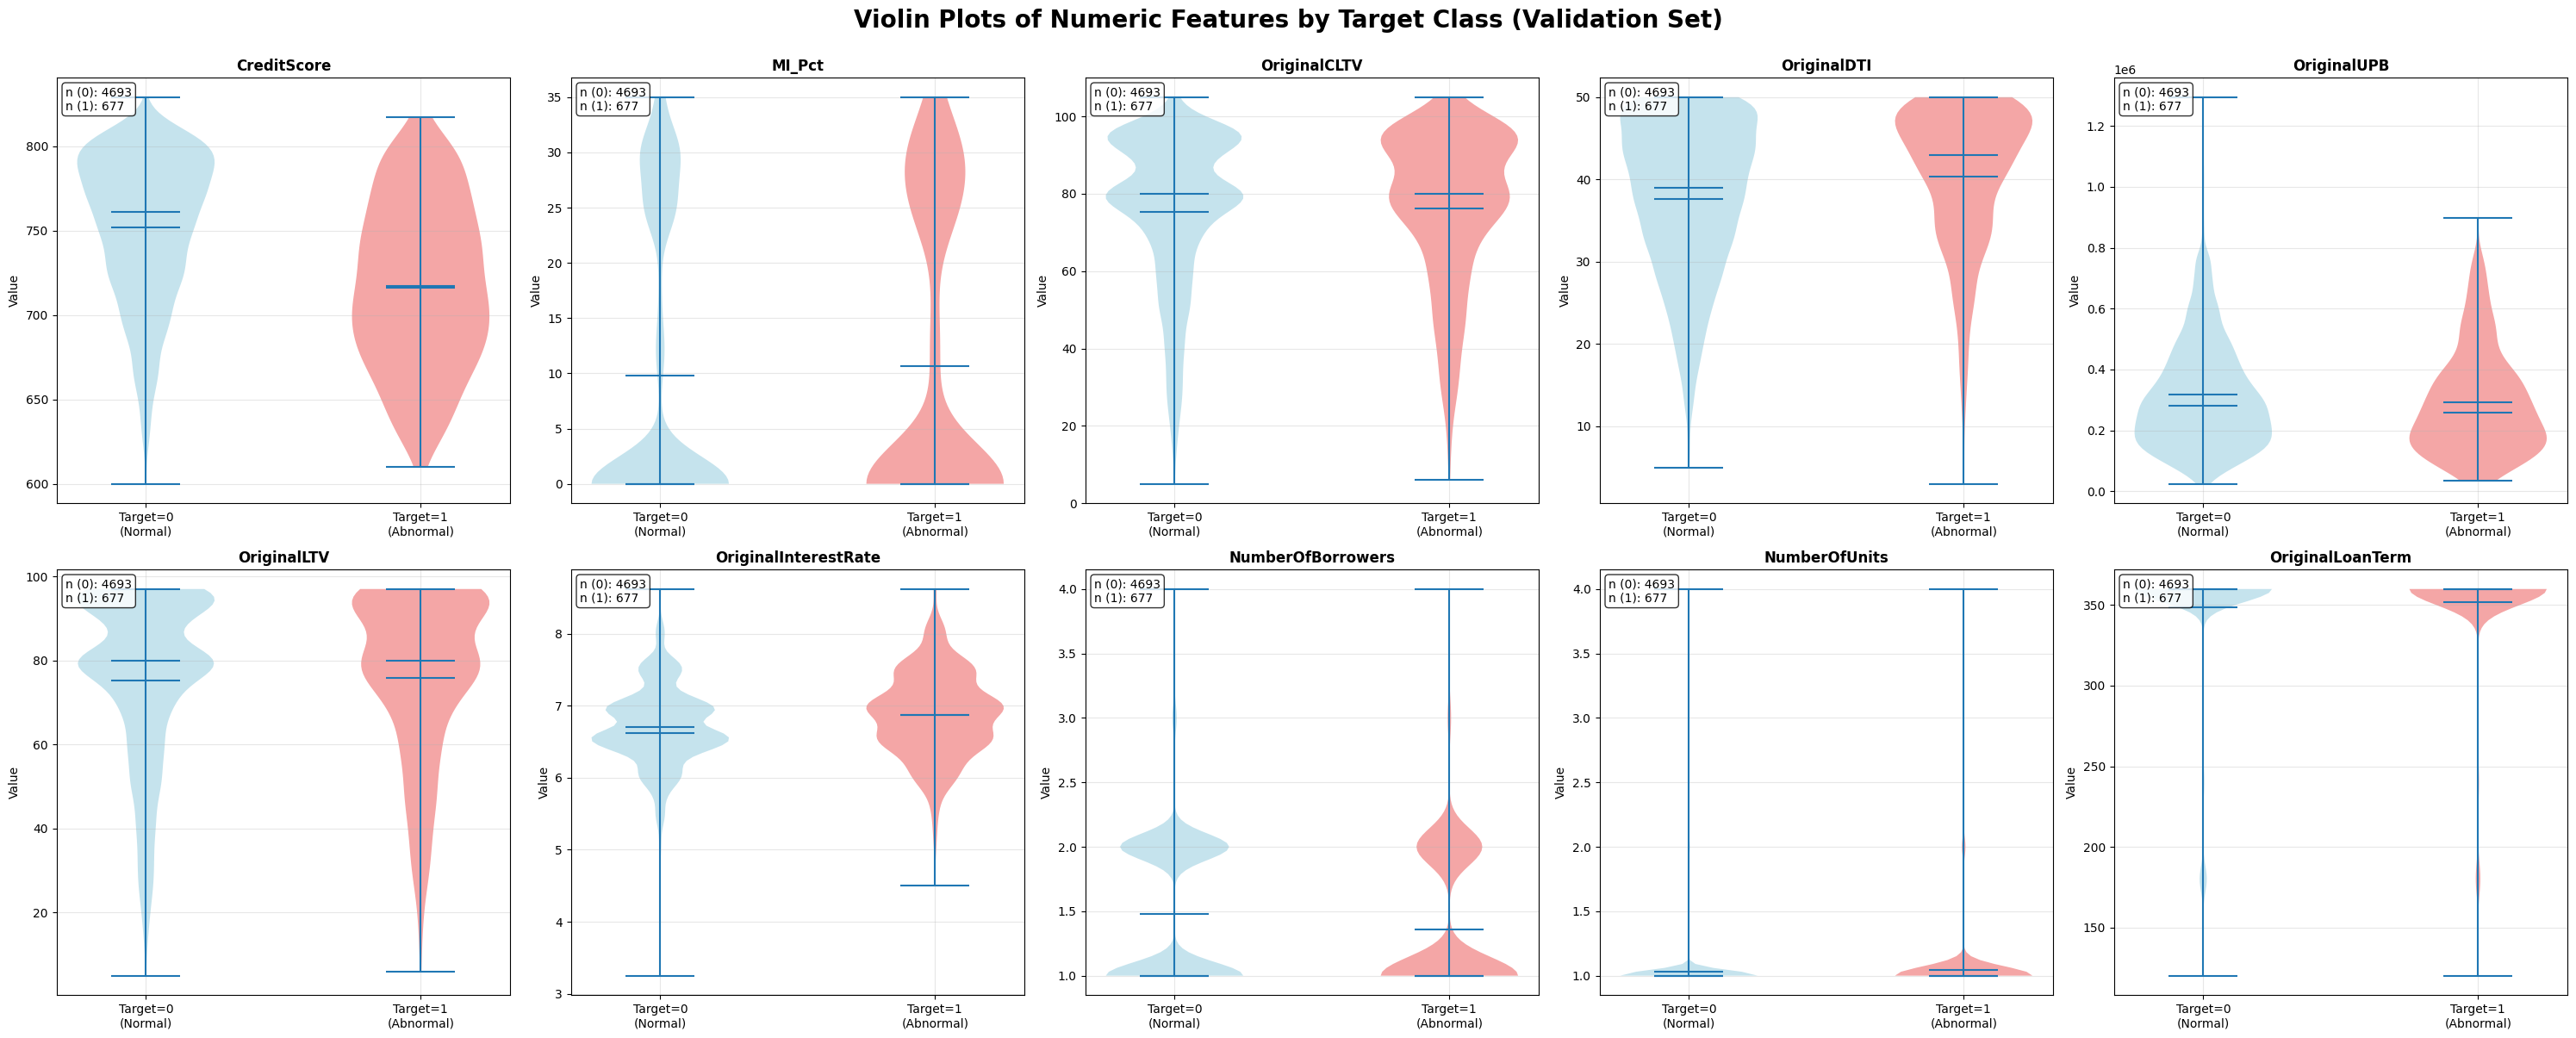

In [ ]:
# 3. VIOLIN PLOTS FOR MORE DETAILED DISTRIBUTION COMPARISON

# Create subplots for violin plots
n_features = len(static_numeric_features)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, feature in enumerate(static_numeric_features):
    if i < len(axes):
        # Prepare data for violin plot
        target_0_data = df_val[df_val['target'] == 0][feature].dropna()
        target_1_data = df_val[df_val['target'] == 1][feature].dropna()
        
        # Create violin plot
        violin_data = [target_0_data, target_1_data]
        violin_labels = ['Target=0\n(Normal)', 'Target=1\n(Abnormal)']
        
        parts = axes[i].violinplot(violin_data, positions=[1, 2], showmeans=True, showmedians=True)
        
        # Color the violins
        parts['bodies'][0].set_facecolor('lightblue')
        parts['bodies'][0].set_alpha(0.7)
        parts['bodies'][1].set_facecolor('lightcoral')
        parts['bodies'][1].set_alpha(0.7)
        
        axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Value', fontsize=10)
        axes[i].set_xticks([1, 2])
        axes[i].set_xticklabels(violin_labels)
        axes[i].grid(True, alpha=0.3)
        
        # Add sample size information
        n_0 = len(target_0_data)
        n_1 = len(target_1_data)
        axes[i].text(0.02, 0.98, f'n (0): {n_0}\nn (1): {n_1}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Title
fig.suptitle('Violin Plots of Numeric Features by Target Class (Validation Set)', 
             fontsize=20, fontweight='bold', y=1)

plt.tight_layout()
plt.show()


- Strong Predictors
    - **CreditScore**
        - Normal loans have significantly higher scores.
    - **OriginalDTI**
        - Normal mean = 37.6, median = 39
        - Anomalous mean = 40.4, median = 43
        - Difference: +2.8 (+7.4%) in mean, +4 (+10.3%) in median
        - Insight: Higher DTI in anomalous loans suggests greater debt burden and repayment risk.
    - **OriginalUPB**
        - Normal mean ≈ 317k, median ≈ 281k
        - nomalous mean ≈ 292k, median ≈ 258k
        - Difference: –25k (–7.8%)
        - Insight: Anomalous loans tend to be smaller; loan size appears to be a reverse risk indicator (smaller loans are riskier).
    - **NumberOfBorrowers**
        - Normal mean = 1.48, anomalous = 1.36 (–8.2%)
        - Median = 1 for both → difference driven by multi-borrower vs. single-borrower cases
        - Insight: Loans with a single borrower are riskier, while multiple borrowers lower default risk.
- Relatively weark predictors
    - **MI_Pct**
        - Anomalous loans are slightly higher (+0.8, +8.3%), but medians are both 0 → weak signal.
    - **OriginalInterestRate**
        - Normal = 6.71, anomalous = 6.87 (+2.4%)
        - Median difference = +0.25
        - Insight: Anomalous loans carry slightly higher interest rates, but the gap is small. 
- No Clear Signal (Weak Predictors)
    - **OriginalCLTV**, **OriginalLTV**, **NumberofUnits**, **OriginalLoanTerm** → show no obvious differences between normal and anomalous loans.

## 3. Dynamic Data Feature Analysis

In [30]:
base_dynamic_features = ['CurrentActualUPB', 'CurrentInterestRate', 'CurrentNonInterestBearingUPB', 
                        'EstimatedLTV', 'InterestBearingUPB', 'LoanAge', 'MonthlyReportingPeriod', 
                        'RemainingMonthsToLegalMaturity']
dynamic_features = [f"{i}_{feat}" for feat in base_dynamic_features for i in range(0, 14)]

print(f"Base dynamic features: {len(base_dynamic_features)}")
print(f"Total dynamic features: {len(dynamic_features)}")
print(f"Time periods: 0-13 (14 periods)")

Base dynamic features: 8
Total dynamic features: 112
Time periods: 0-13 (14 periods)


- CurrentActualUPB = CurrentNonInterestBearingUPB + InterestBearingUPB -> Can be deleted directly
- MonthlyReportingPeriod: specific date is NOT important, the time from beginning is the more important one, which is exactly LoanAge
- RemainingMonthsToLegalMaturity: Can be calculated, maybe overlaps with LoanAge...?

#### 3.1 Distirbution in training set

In [33]:
df[[f"13_{feat}" for feat in base_dynamic_features]]

,13_CurrentActualUPB,13_CurrentInterestRate,13_CurrentNonInterestBearingUPB,13_EstimatedLTV,13_InterestBearingUPB,13_LoanAge,13_MonthlyReportingPeriod,13_RemainingMonthsToLegalMaturity
0,81190.87,8.000,0.0,999,81190.87,13,202503,347
1,301932.72,7.875,0.0,64,301932.72,13,202503,347
2,152044.42,7.625,0.0,999,152044.42,13,202503,347
3,50045.91,7.250,0.0,70,50045.91,13,202503,347
4,153521.39,7.750,0.0,63,153521.39,13,202503,347
...,...,...,...,...,...,...,...,...
30499,265227.66,8.125,0.0,83,265227.66,13,202503,347
30500,309908.70,6.125,0.0,26,309908.70,13,202503,347
30501,59337.74,7.000,0.0,37,59337.74,13,202503,347
30502,509137.67,5.875,0.0,86,509137.67,13,202503,347


In [40]:
# 1. BASIC STATISTICS FOR DYNAMIC FEATURES

# Calculate basic statistics for each base dynamic feature across all time periods
dynamic_stats = []

for base_feature in base_dynamic_features:
    # Get all columns for this feature across time periods
    feature_cols = [f"{i}_{base_feature}" for i in range(14)]
    
    # Calculate statistics across all time periods
    all_values = []
    missing_counts = []
    
    for col in feature_cols:
        if col in df.columns:
            values = df[col].dropna()
            all_values.extend(values.tolist())
            missing_count = df[col].isnull().sum()
            missing_counts.append(missing_count)
    
    if all_values:
        all_values = np.array(all_values)
        
        dynamic_stats.append({
            'Feature': base_feature,
            'Total_Values': len(all_values),
            'Missing_Values': sum(missing_counts),
            'Missing_Pct': f"{(sum(missing_counts) / (len(df) * 14)) * 100:.2f}%",
            'Mean': f"{np.mean(all_values):.2f}",
            'Median': f"{np.median(all_values):.2f}",
            'Std': f"{np.std(all_values):.2f}",
            'Min': f"{np.min(all_values):.2f}",
            'Max': f"{np.max(all_values):.2f}",
            'Q1': f"{np.percentile(all_values, 25):.2f}",
            'Q3': f"{np.percentile(all_values, 75):.2f}",
            'Skewness': f"{pd.Series(all_values).skew():.3f}",
            'Kurtosis': f"{pd.Series(all_values).kurtosis():.3f}"
        })

dynamic_stats_df = pd.DataFrame(dynamic_stats)
print("DYNAMIC FEATURES SUMMARY STATISTICS:")
print("=" * 80)
print(dynamic_stats_df.to_string(index=False))


DYNAMIC FEATURES SUMMARY STATISTICS:
                       Feature  Total_Values  Missing_Values Missing_Pct      Mean    Median       Std       Min        Max        Q1        Q3 Skewness Kurtosis
              CurrentActualUPB        427056               0       0.00% 309838.62 271000.00 178954.83      0.00 1700000.00 176880.89 405000.00    1.081    1.391
           CurrentInterestRate        427056               0       0.00%      6.72      6.62      0.55      2.50       9.12      6.38      7.00    0.009    0.926
  CurrentNonInterestBearingUPB        427056               0       0.00%      0.00      0.00      0.00      0.00       0.00      0.00      0.00    0.000    0.000
                  EstimatedLTV        427056               0       0.00%    148.46     77.00    258.03      1.00     999.00     62.00     89.00    2.973    6.911
            InterestBearingUPB        427056               0       0.00% 309838.62 271000.00 178954.83      0.00 1700000.00 176880.89 405000.00    1.081 

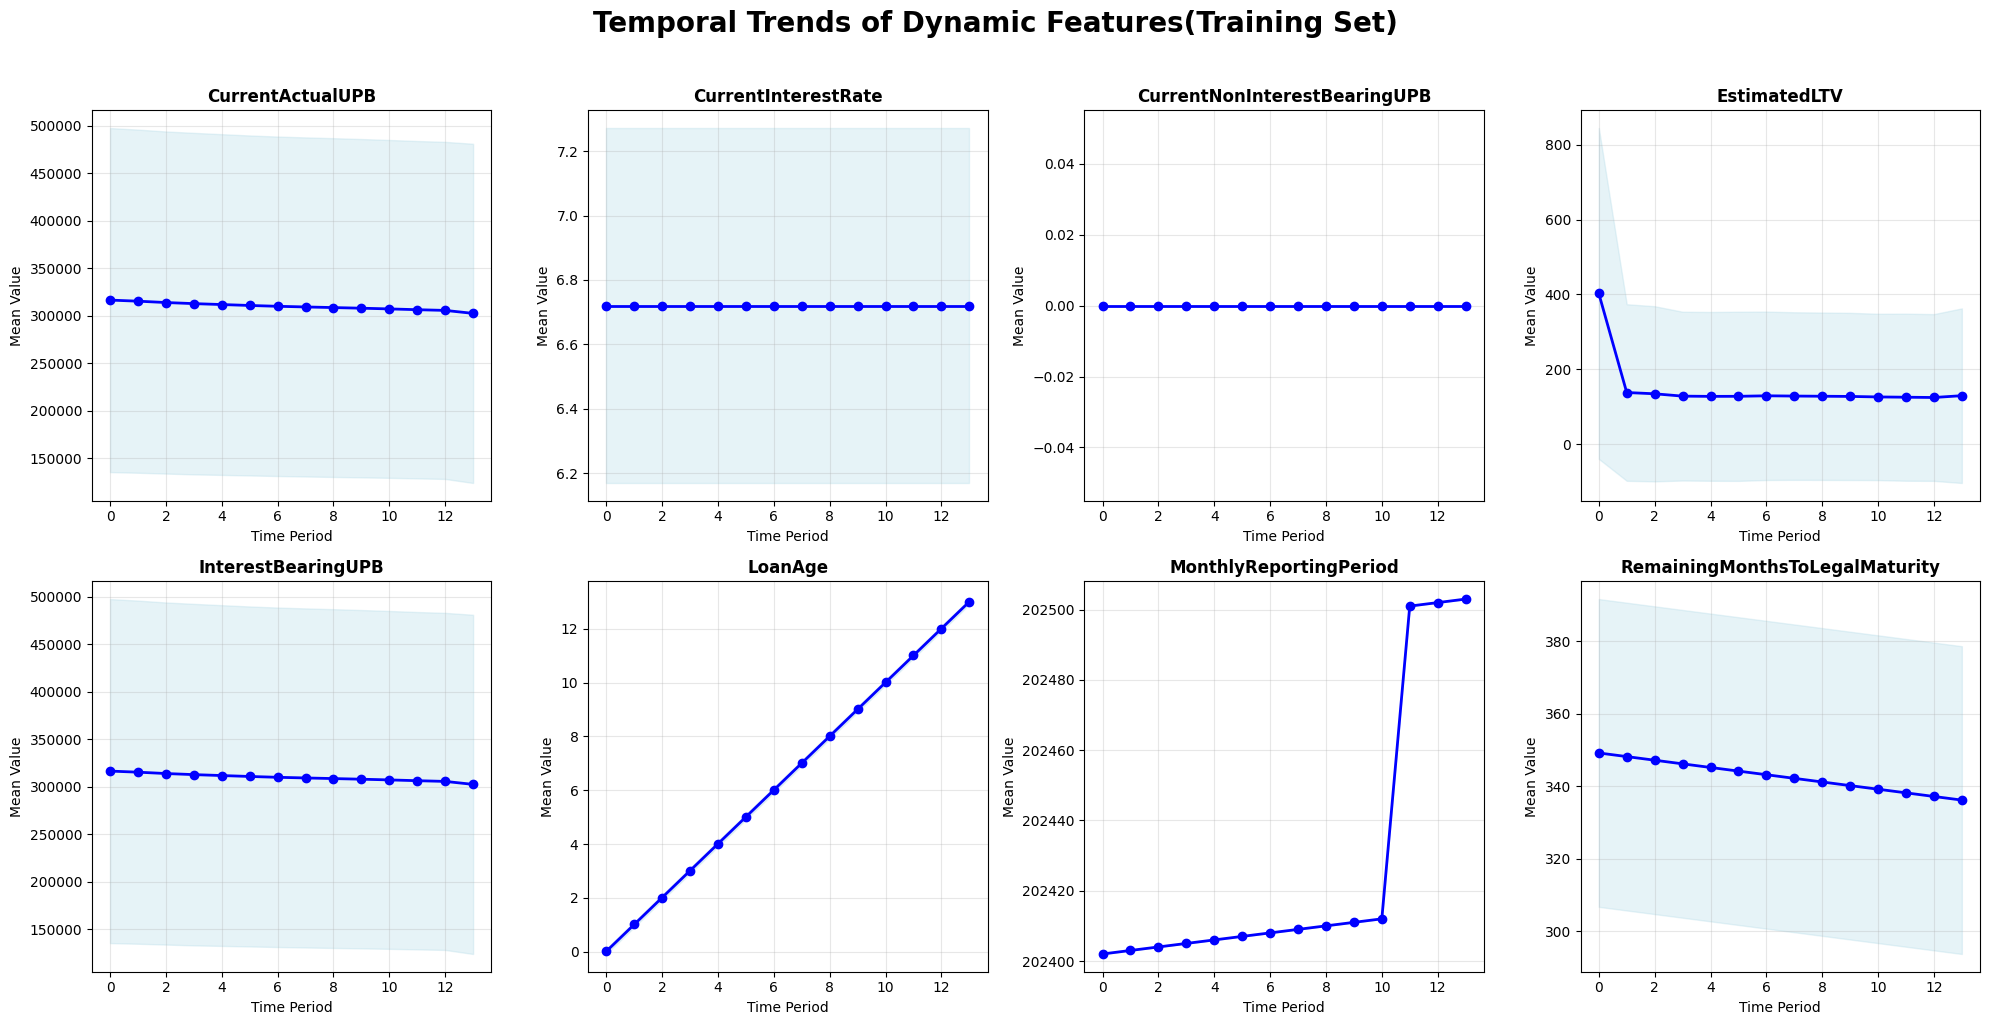

In [9]:
# 2. VISUALIZATION - Temporal trends for each dynamic feature

# Create subplots for temporal trend visualization
n_features = len(base_dynamic_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, base_feature in enumerate(base_dynamic_features):
    if i < len(axes):
        # Get data for all time periods
        periods = []
        means = []
        stds = []
        
        for period in range(14):
            col = f"{period}_{base_feature}"
            if col in df.columns:
                values = df[col].dropna()
                if len(values) > 0:
                    periods.append(period)
                    means.append(values.mean())
                    stds.append(values.std())
        
        # Plot temporal trend
        axes[i].plot(periods, means, marker='o', linewidth=2, markersize=6, color='blue')
        axes[i].fill_between(periods, 
                           [m - s for m, s in zip(means, stds)], 
                           [m + s for m, s in zip(means, stds)], 
                           alpha=0.3, color='lightblue')
        
        axes[i].set_title(f'{base_feature}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Period', fontsize=10)
        axes[i].set_ylabel('Mean Value', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(0, 14, 2))

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Add overall title
fig.suptitle('Temporal Trends of Dynamic Features(Training Set)', 
             fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()


#### 3.2 Distribution in validation set

In [46]:
# 1. BASIC STATISTICS COMPARISON FOR DYNAMIC FEATURES

# Calculate statistics for each base dynamic feature across all time periods
comparison_stats = []

for base_feature in base_dynamic_features:
    # Get all columns for this feature across time periods
    feature_cols = [f"{i}_{base_feature}" for i in range(14)]
    
    # Calculate statistics for target=0 (normal loans)
    target_0_values = []
    target_1_values = []
    
    for col in feature_cols:
        if col in df_val.columns:
            # Target = 0 (normal loans)
            values_0 = df_val[df_val['target'] == 0][col].dropna()
            target_0_values.extend(values_0.tolist())
            
            # Target = 1 (abnormal loans)
            values_1 = df_val[df_val['target'] == 1][col].dropna()
            target_1_values.extend(values_1.tolist())
    
    if target_0_values and target_1_values:
        target_0_array = np.array(target_0_values)
        target_1_array = np.array(target_1_values)
        
        # Calculate differences
        mean_diff = np.mean(target_1_array) - np.mean(target_0_array)
        mean_pct_diff = (mean_diff / np.mean(target_0_array)) * 100 if np.mean(target_0_array) != 0 else 0
        
        median_diff = np.median(target_1_array) - np.median(target_0_array)
        median_pct_diff = (median_diff / np.median(target_0_array)) * 100 if np.median(target_0_array) != 0 else 0
        
        comparison_stats.append({
            'Feature': base_feature,
            'Target_0_Mean': f"{np.mean(target_0_array):.2f}",
            'Target_1_Mean': f"{np.mean(target_1_array):.2f}",
            'Mean_Diff': f"{mean_diff:.2f}",
            'Mean_Pct_Diff': f"{mean_pct_diff:.1f}%",
            'Target_0_Median': f"{np.median(target_0_array):.2f}",
            'Target_1_Median': f"{np.median(target_1_array):.2f}",
            'Median_Diff': f"{median_diff:.2f}",
            'Median_Pct_Diff': f"{median_pct_diff:.1f}%",
            'Target_0_Std': f"{np.std(target_0_array):.2f}",
            'Target_1_Std': f"{np.std(target_1_array):.2f}"
        })

comparison_df = pd.DataFrame(comparison_stats)
print("DYNAMIC FEATURES COMPARISON: TARGET=0 vs TARGET=1")
print("=" * 100)
print(comparison_df.to_string(index=False))


DYNAMIC FEATURES COMPARISON: TARGET=0 vs TARGET=1
                       Feature Target_0_Mean Target_1_Mean Mean_Diff Mean_Pct_Diff Target_0_Median Target_1_Median Median_Diff Median_Pct_Diff Target_0_Std Target_1_Std
              CurrentActualUPB     308715.75     287599.30 -21116.45         -6.8%       274811.48       250000.00   -24811.48           -9.0%    175035.53    168452.03
           CurrentInterestRate          6.71          6.87      0.16          2.4%            6.62            6.88        0.25            3.8%         0.55         0.59
  CurrentNonInterestBearingUPB          0.00         74.35     74.35          0.0%            0.00            0.00        0.00            0.0%         0.00      1166.54
                  EstimatedLTV        147.72        162.92     15.20         10.3%           77.00           78.00        1.00            1.3%       257.24       276.92
            InterestBearingUPB     308715.75     287525.06 -21190.70         -6.9%       274811.48       

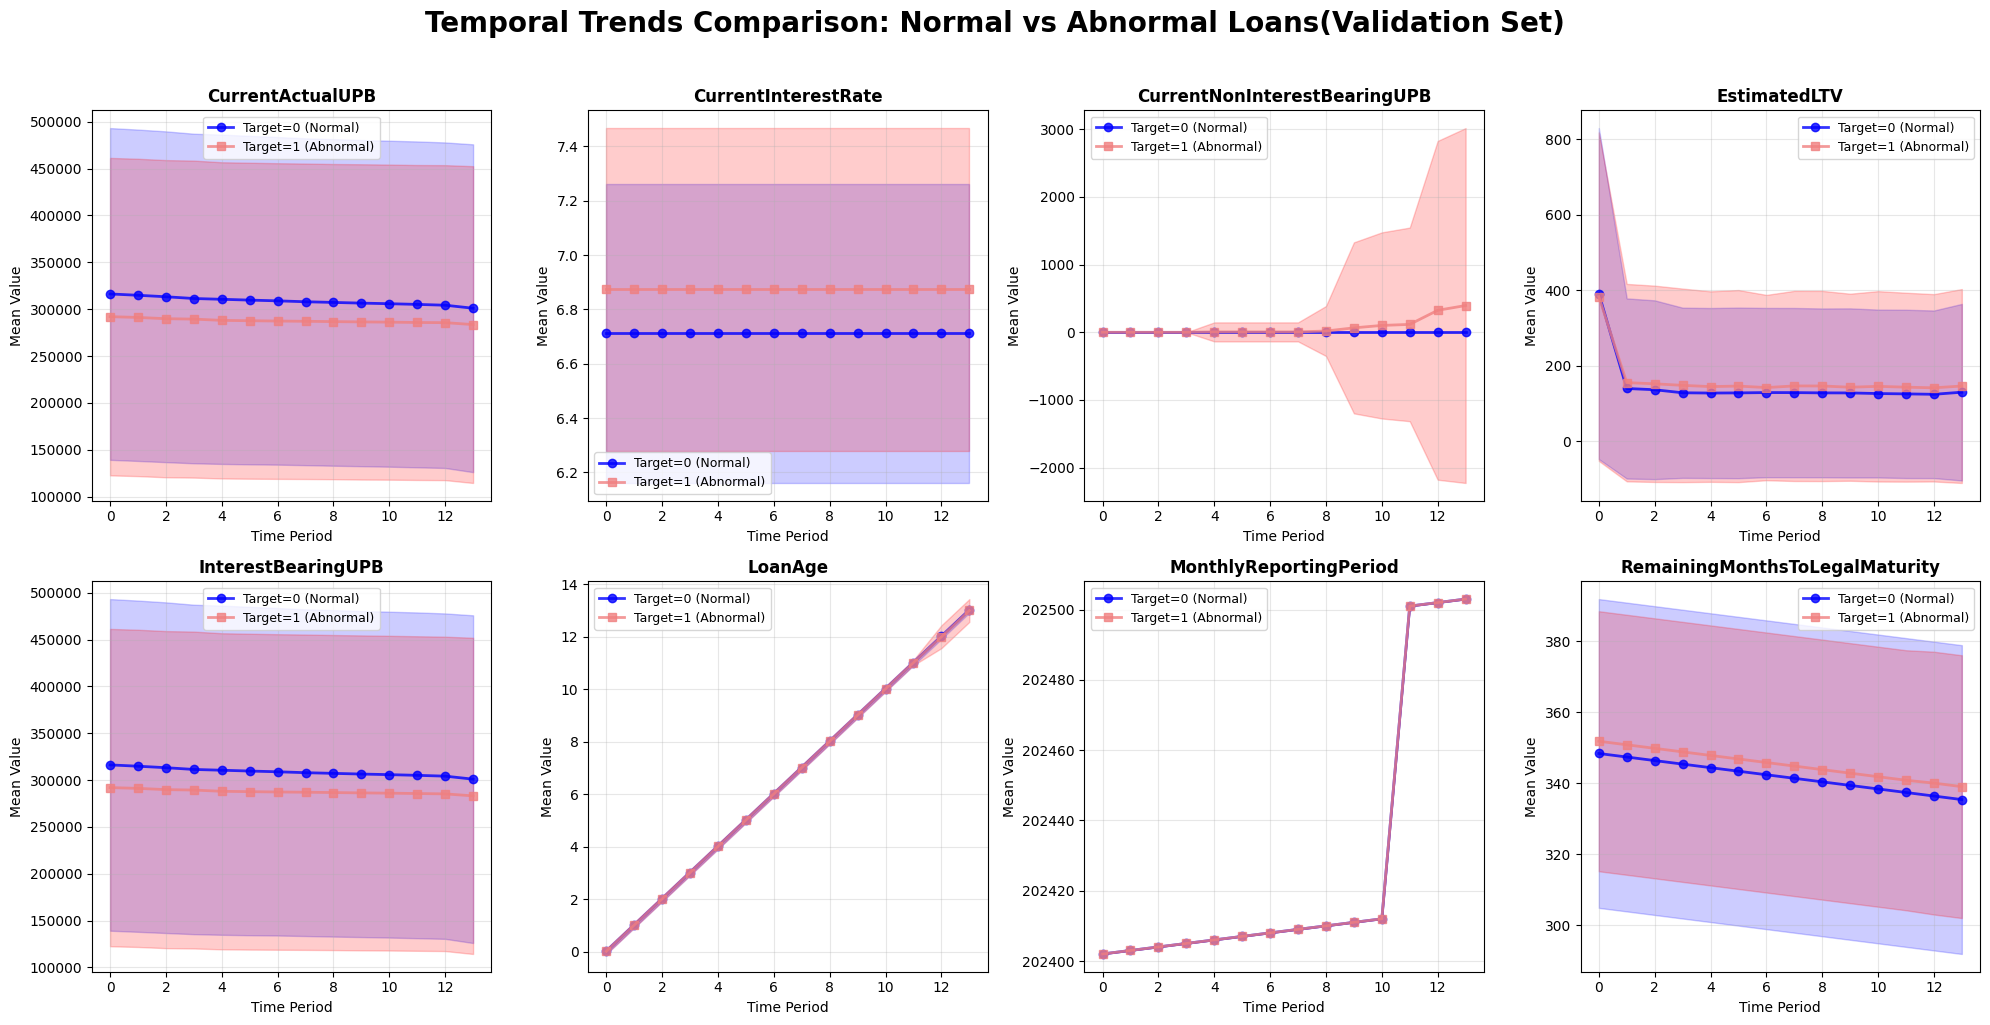

In [8]:
# 2. TEMPORAL TREND COMPARISON - Mean values across time periods

# Create subplots for temporal trend comparison
n_features = len(base_dynamic_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, base_feature in enumerate(base_dynamic_features):
    if i < len(axes):
        # Get data for all time periods
        periods = []
        means_0 = []  # Target = 0
        means_1 = []  # Target = 1
        stds_0 = []
        stds_1 = []
        
        for period in range(14):
            col = f"{period}_{base_feature}"
            if col in df_val.columns:
                # Target = 0
                values_0 = df_val[df_val['target'] == 0][col].dropna()
                # Target = 1
                values_1 = df_val[df_val['target'] == 1][col].dropna()
                
                if len(values_0) > 0 and len(values_1) > 0:
                    periods.append(period)
                    means_0.append(values_0.mean())
                    means_1.append(values_1.mean())
                    stds_0.append(values_0.std())
                    stds_1.append(values_1.std())
                    
        # Plot temporal trends
        axes[i].plot(periods, means_0, marker='o', linewidth=2, markersize=6, 
                    color='blue', label='Target=0 (Normal)', alpha=0.8)
        axes[i].plot(periods, means_1, marker='s', linewidth=2, markersize=6, 
                    color='lightcoral', label='Target=1 (Abnormal)', alpha=0.8)
        
        # Add confidence intervals
        axes[i].fill_between(periods, 
                           [m - s for m, s in zip(means_0, stds_0)], 
                           [m + s for m, s in zip(means_0, stds_0)], 
                           alpha=0.2, color='blue')
        axes[i].fill_between(periods, 
                           [m - s for m, s in zip(means_1, stds_1)], 
                           [m + s for m, s in zip(means_1, stds_1)], 
                           alpha=0.2, color='red')
        
        axes[i].set_title(f'{base_feature}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Period', fontsize=10)
        axes[i].set_ylabel('Mean Value', fontsize=10)
        axes[i].legend(fontsize=9)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(0, 14, 2))

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Add overall title
fig.suptitle('Temporal Trends Comparison: Normal vs Abnormal Loans(Validation Set)', 
             fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()


- **CurrentActualUPB** / **InterestBearingUPB**
    - Anomalous loans have lower balances.
- **CurrentInterestRate**
    - Anomalous loans have higher interest rates.
- **CurrentNonInterestBearingUPB**
    - Normal loans ≈ 0, anomalous mean = 74.
    - Very high standard deviation (1166).
    - Almost all normal samples are zero, but some anomalous loans have nonzero values — this may serve as a strong anomaly signal.
- **EstimatedLTV**
    - Anomalous mean is higher (162.9 vs. 147.7, +10.3%), though the median difference is small.
    - High variance (Std ≈ 270).
    - On average, anomalous loans have higher LTV, but individual variation is large.
- **LoanAge** / **RemainingMonthsToLegalMaturity** / **MonthlyReportingPeriod**
    - Show almost no discriminative power.